# Deep Learning Attack on EdDSA

## 1. Dataset Preparation
### 1.1 Loading the Dataset

In [172]:
import h5py
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [173]:
# Load and preprocess the dataset
file_path = 'databaseEdDSA.h5'
with h5py.File(file_path, 'r') as file:
    # List all groups
    print("Keys: %s" % list(file.keys()))
    # 'Attack_traces' and 'Profiling_traces' are groups containing datasets
    # Let's list what is inside these groups to understand better
    print("Attack_traces contents: %s" % list(file['Attack_traces'].keys()))
    print("Profiling_traces contents: %s" % list(file['Profiling_traces'].keys()))

    # Load the datasets to the appropriate numpy arrays
    test_data = file['Attack_traces/traces'][:]
    train_data = file['Profiling_traces/traces'][:]
    test_targets = file['Attack_traces/label'][:]
    train_targets = file['Profiling_traces/label'][:]

# Print the dataset shapes before reshaping
print("\nDataset shapes before reshaping:")
print("Training traces shape:", train_data.shape)
print("Training labels shape:", train_targets.shape)
print("Test traces shape:", test_data.shape)
print("Test labels shape:", test_targets.shape)

Keys: ['Attack_traces', 'Profiling_traces']
Attack_traces contents: ['label', 'traces']
Profiling_traces contents: ['label', 'traces']

Dataset shapes before reshaping:
Training traces shape: (5120, 1000)
Training labels shape: (5120,)
Test traces shape: (1280, 1000)
Test labels shape: (1280,)


### 1.2 Reshaping the Dataset

In [174]:
# Reshape the traces to be compatible with CNN input
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))

# Print the dataset shapes after reshaping
print("\nDataset shapes after reshaping:")
print("Training traces shape:", train_data.shape)
print("Training labels shape:", train_targets.shape)
print("Test traces shape:", test_data.shape)
print("Test labels shape:", test_targets.shape)


Dataset shapes after reshaping:
Training traces shape: (5120, 1000, 1)
Training labels shape: (5120,)
Test traces shape: (1280, 1000, 1)
Test labels shape: (1280,)


### 1.3 Shuffling the Dataset

In [175]:
# Shuffle the training dataset
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
train_data = train_data[indices]
train_targets = train_targets[indices]

## 2. Building the CNN Model
### 2.1 Defining the CNN Architecture

In [176]:
# Define the CNN model
def create_cnn_model(input_length, num_classes):
    model = Sequential()

    # Layer 1
    model.add(Conv1D(filters=min(8 * (2 ** 0), 512), kernel_size=3, activation='relu', padding='same',
                     input_shape=(input_length, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # Layer 2
    model.add(Conv1D(filters=min(8 * (2 ** 1), 512), kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # Layer 3
    model.add(Conv1D(filters=min(8 * (2 ** 2), 512), kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # Layer 4
    model.add(Conv1D(filters=min(8 * (2 ** 3), 512), kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # Layer 5
    model.add(Conv1D(filters=min(8 * (2 ** 4), 512), kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # Layer 6
    model.add(Conv1D(filters=min(8 * (2 ** 5), 512), kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # Layer 7
    model.add(Conv1D(filters=min(8 * (2 ** 6), 512), kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # Layer 8
    model.add(Conv1D(filters=min(8 * (2 ** 7), 512), kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # Layer 9
    model.add(Conv1D(filters=min(8 * (2 ** 8), 512), kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # Add the first dropout layer
    model.add(Dropout(0.5))

    # Flatten the output from the convolutional layers
    model.add(Flatten())

    # Add fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


input_length = train_data.shape[1]  # Shape of the input traces (number of samples per trace)
num_classes = len(np.unique(train_targets))  # Number of unique classes in the dataset

cnn_model = create_cnn_model(input_length, num_classes)
cnn_model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Print the model summary
cnn_model.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_117 (Conv1D)         (None, 1000, 8)           32        
                                                                 
 batch_normalization_65 (Ba  (None, 1000, 8)           32        
 tchNormalization)                                               
                                                                 
 max_pooling1d_117 (MaxPool  (None, 500, 8)            0         
 ing1D)                                                          
                                                                 
 conv1d_118 (Conv1D)         (None, 500, 16)           400       
                                                                 
 max_pooling1d_118 (MaxPool  (None, 250, 16)           0         
 ing1D)                                                          
                                                     

## 3. Training the CNN Model
### 3.1 Training the CNN Model

In [177]:
# Train the model
history = cnn_model.fit(train_data, train_targets, epochs=25, validation_split=0.3)

# Save the model
cnn_model.save('cnn_model.keras')

# Report the training and validation accuracy and loss
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
training_loss = history.history['loss'][-1]
validation_loss = history.history['val_loss'][-1]
print(f"\nTraining Accuracy: {training_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Training Loss: {training_loss:.4f}")
print(f"Validation Loss: {validation_loss:.4f}")

Epoch 1/25
112/112 [==============================] - 17s 119ms/step - loss: 0.7377 - accuracy: 0.7899 - val_loss: 4.3272 - val_accuracy: 0.0645
Epoch 2/25
112/112 [==============================] - 11s 102ms/step - loss: 0.0086 - accuracy: 0.9980 - val_loss: 4.6380 - val_accuracy: 0.0723
Epoch 3/25
112/112 [==============================] - 13s 112ms/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 4.7493 - val_accuracy: 0.0677
Epoch 4/25
112/112 [==============================] - 12s 109ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 5.0165 - val_accuracy: 0.0632
Epoch 5/25
112/112 [==============================] - 12s 112ms/step - loss: 0.0101 - accuracy: 0.9972 - val_loss: 3.4099 - val_accuracy: 0.1810
Epoch 6/25
112/112 [==============================] - 12s 111ms/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.3576 - val_accuracy: 0.8379
Epoch 7/25
112/112 [==============================] - 13s 113ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0050 - val_ac

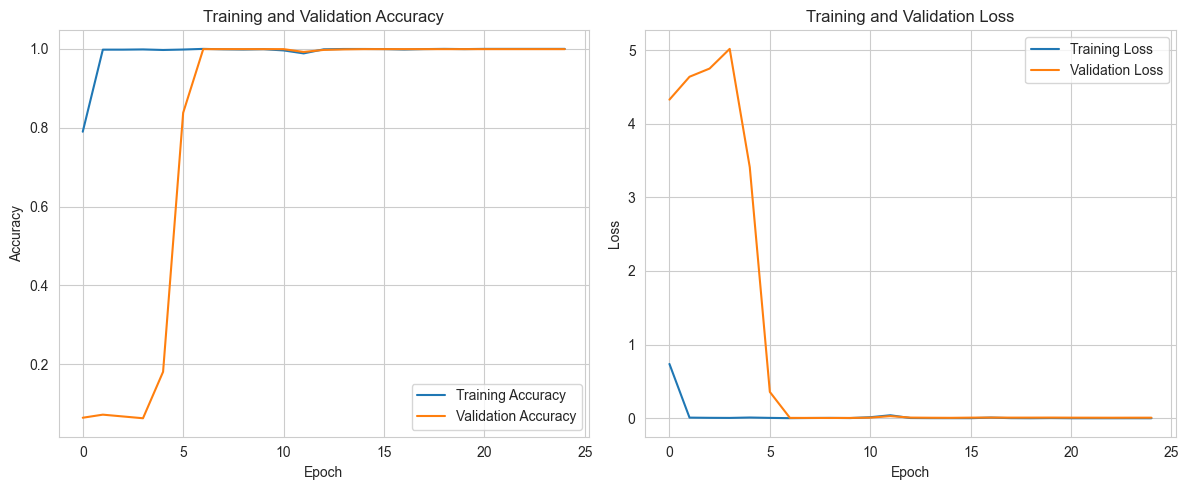

In [178]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot the training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 3.2 Evaluating the CNN Model on Attack Trace

In [179]:
# Determine the index of the attack trace based on the student numbers
sNum1 = 1132644
sNum2 = 1112354

index = (int(str(sNum1)[-2:]) + int(str(sNum2)[-2:])) % 16

print(f'Index of the attack trace: {index}')

Index of the attack trace: 2


In [180]:
# Select the single attack trace from the attack set
single_attack_trace = np.reshape(test_data[index], (1, test_data.shape[1], 1))

# Make a prediction for the attack trace using the trained model
predicted_key = np.argmax(cnn_model.predict(single_attack_trace), axis=1)

# Print the predicted key and the actual key
print(f'Predicted key for the attack trace: {predicted_key[0]}, Actual key: {test_targets[index]}')

1/1 [==============================] - 1s 524ms/step
Predicted key for the attack trace: 12, Actual key: 12


40/40 [==============================] - 1s 17ms/step


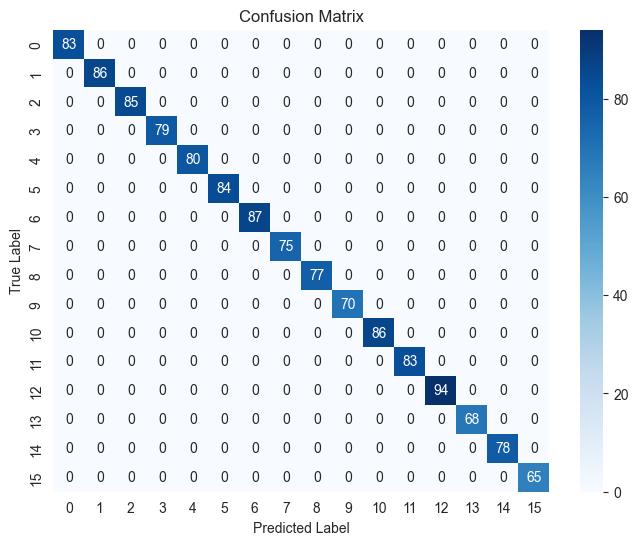

Number of correct predictions: 1280
Number of incorrect predictions: 0
Accuracy: 1.0000


In [181]:
# Predict the probabilities for the attack set
predicted_probabilities = cnn_model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_targets, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_targets),
            yticklabels=np.unique(test_targets))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the number of correct and incorrect predictions
num_correct = np.sum(test_targets == predicted_labels)
num_incorrect = len(test_targets) - num_correct

print(f'Number of correct predictions: {num_correct}')
print(f'Number of incorrect predictions: {num_incorrect}')
# Print accuracy for attack set
accuracy = num_correct / len(test_targets)
print(f'Accuracy: {accuracy:.4f}')

## 4. Repeated Training and Evaluation
### 4.1 Training the Model for 5 Epochs 10 Times


******************************
Run 1
******************************

Training Accuracy: 0.9997
Validation Accuracy: 0.3164
Training Loss: 0.0016
Validation Loss: 2.2820


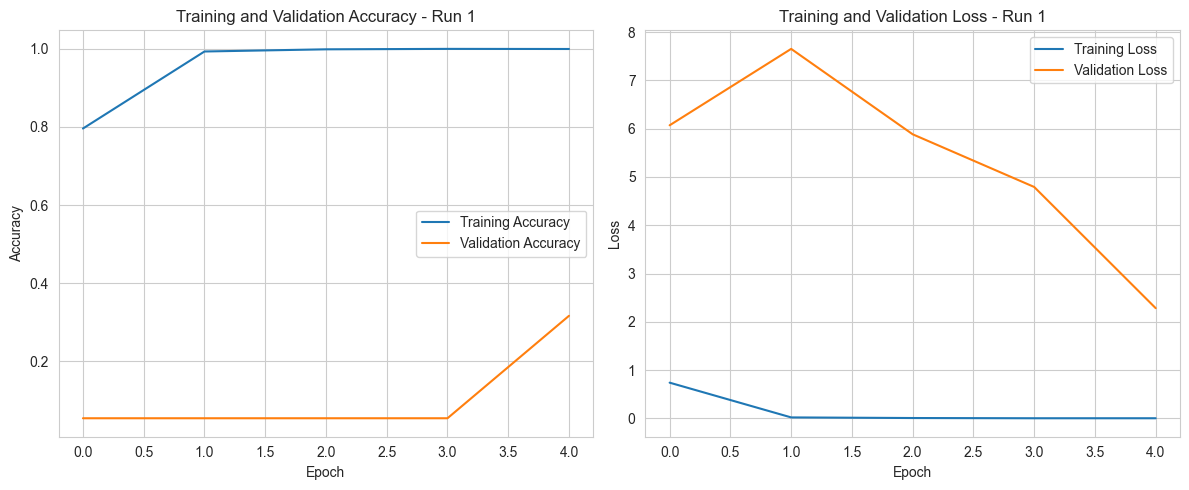

40/40 [==============================] - 1s 18ms/step


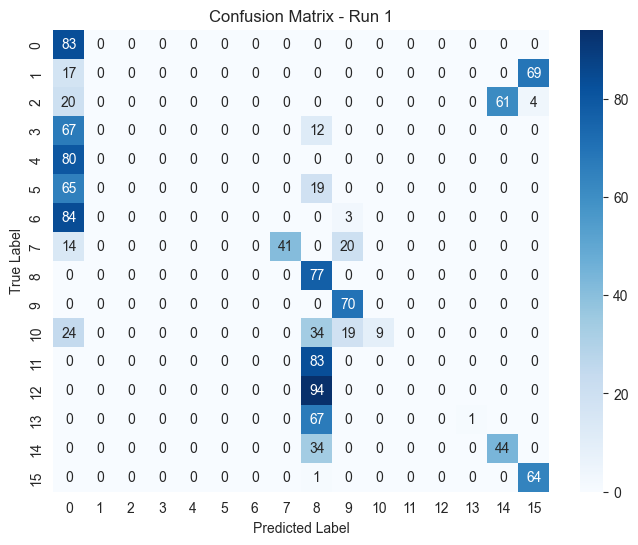

Number of correct predictions: 389
Number of incorrect predictions: 891

******************************
Run 2
******************************

Training Accuracy: 0.9967
Validation Accuracy: 0.4329
Training Loss: 0.0083
Validation Loss: 2.8257


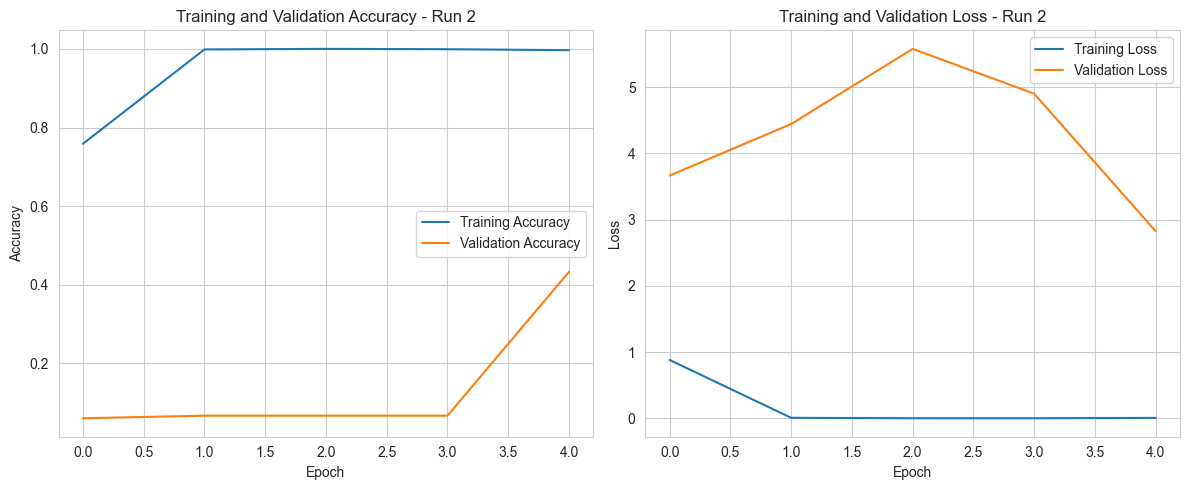

40/40 [==============================] - 1s 17ms/step


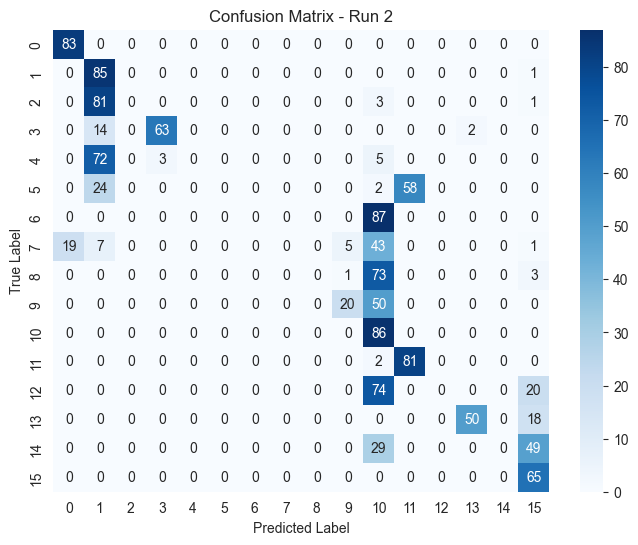

Number of correct predictions: 533
Number of incorrect predictions: 747

******************************
Run 3
******************************

Training Accuracy: 0.9997
Validation Accuracy: 0.1706
Training Loss: 0.0027
Validation Loss: 4.4778


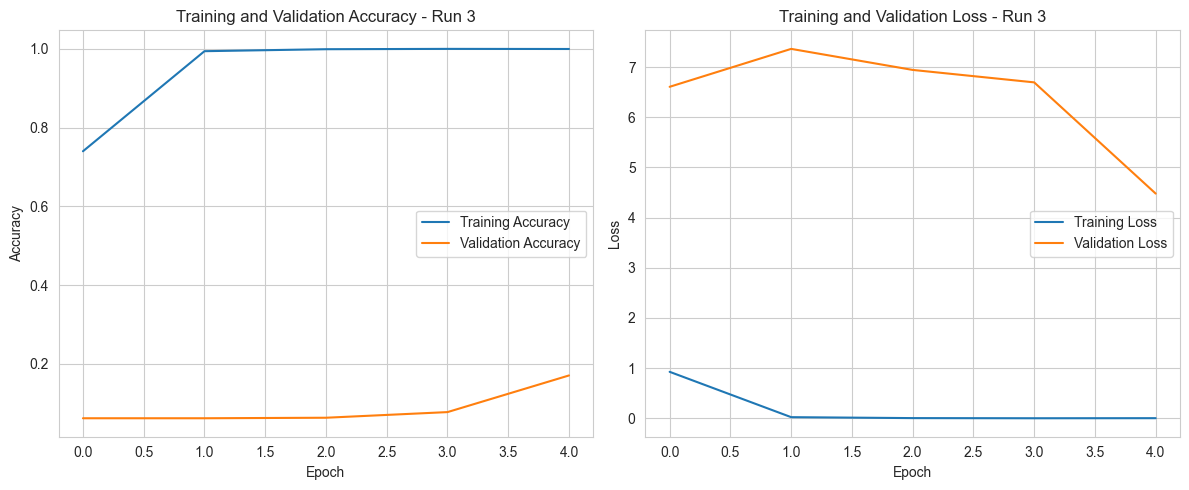

40/40 [==============================] - 1s 17ms/step


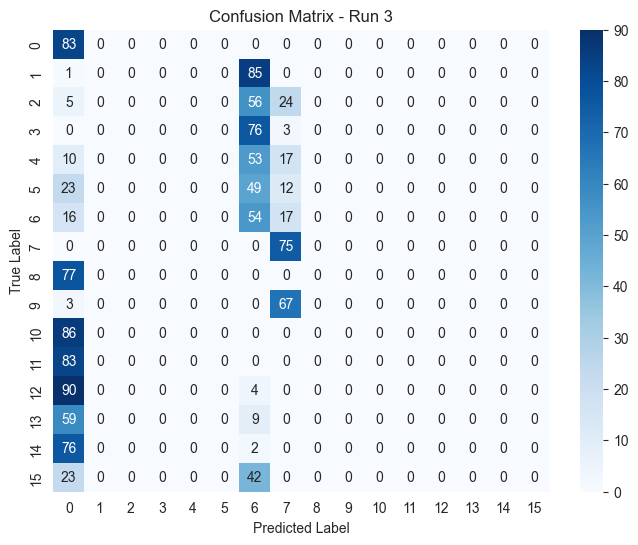

Number of correct predictions: 212
Number of incorrect predictions: 1068

******************************
Run 4
******************************

Training Accuracy: 0.9997
Validation Accuracy: 0.1178
Training Loss: 0.0020
Validation Loss: 2.9973


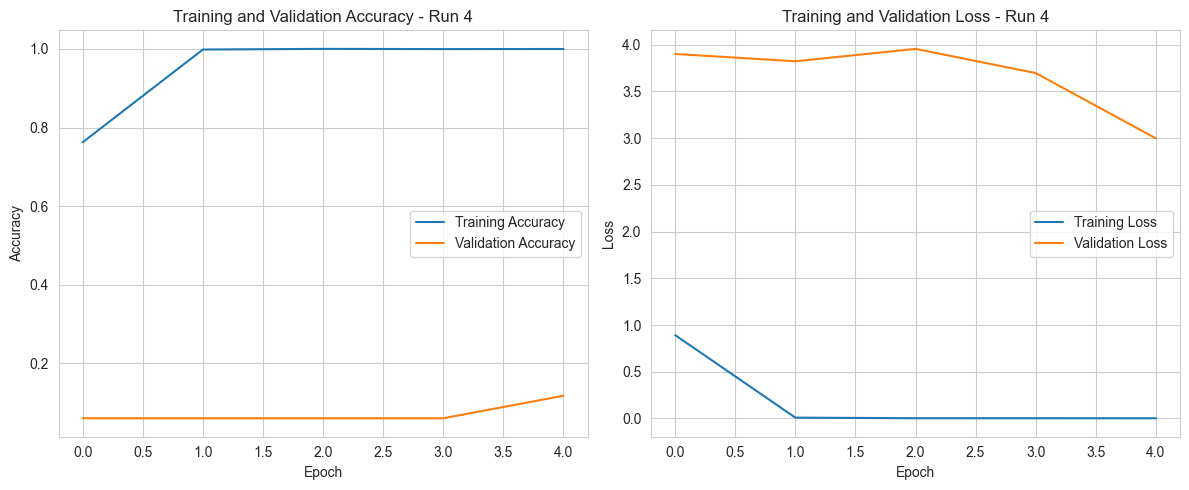

40/40 [==============================] - 1s 17ms/step


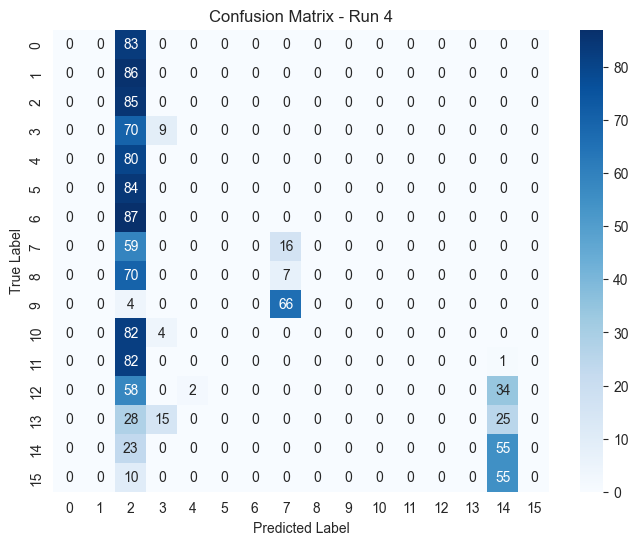

Number of correct predictions: 165
Number of incorrect predictions: 1115

******************************
Run 5
******************************

Training Accuracy: 0.9994
Validation Accuracy: 0.1621
Training Loss: 0.0013
Validation Loss: 4.9772


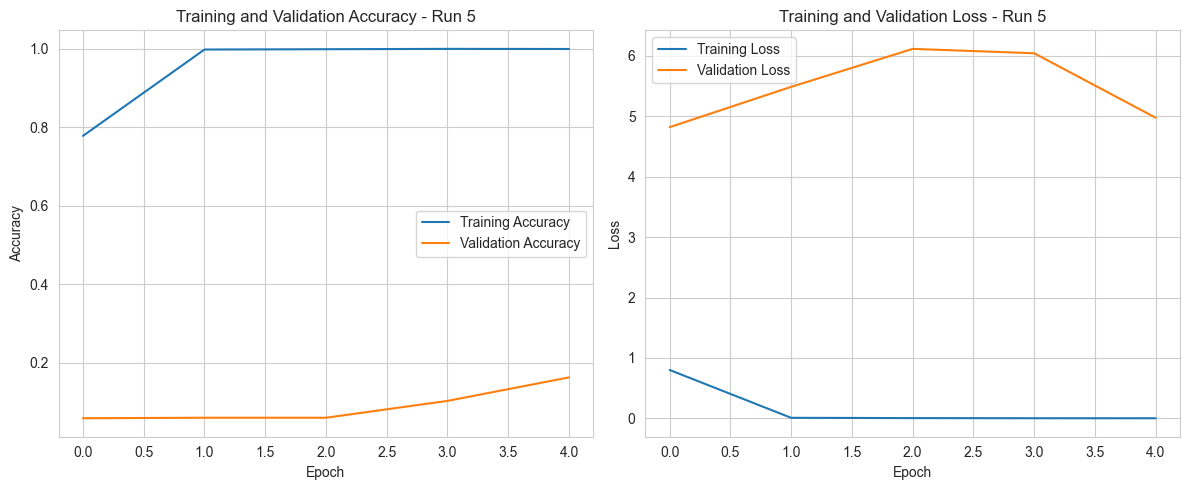

40/40 [==============================] - 1s 17ms/step


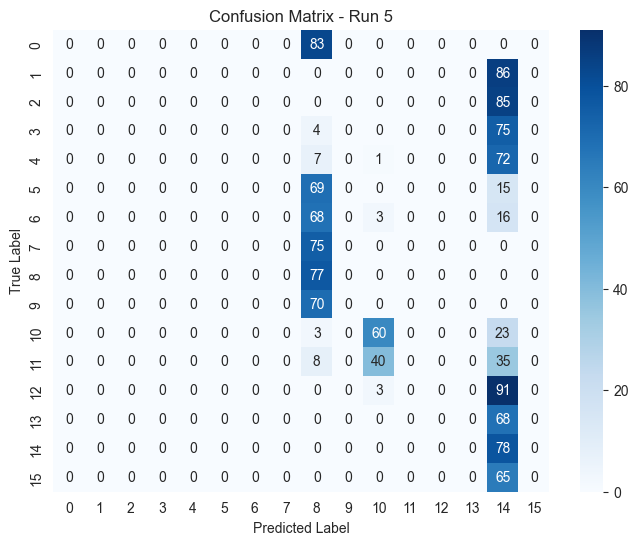

Number of correct predictions: 215
Number of incorrect predictions: 1065

******************************
Run 6
******************************

Training Accuracy: 0.9997
Validation Accuracy: 0.1126
Training Loss: 0.0018
Validation Loss: 4.5359


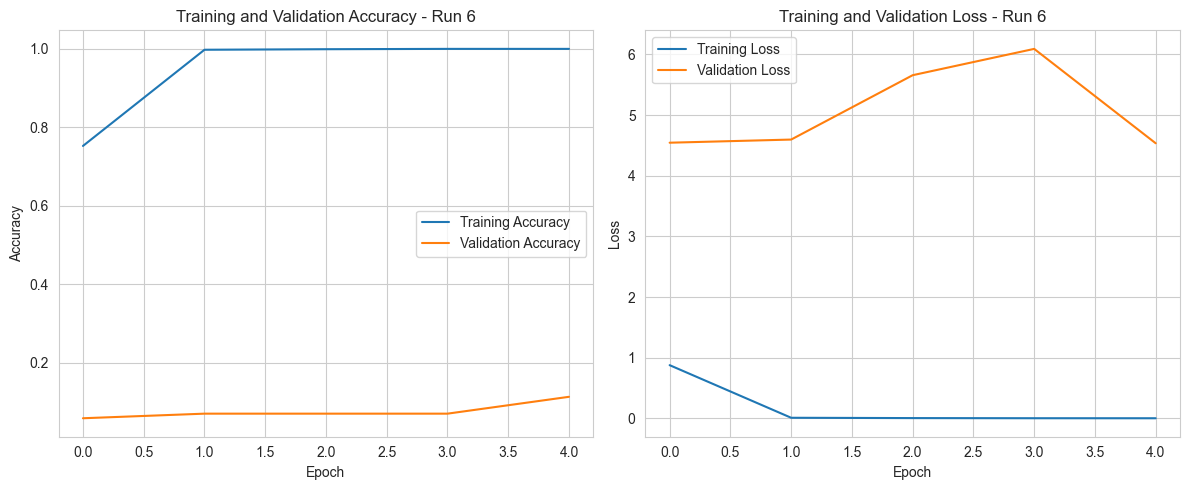

40/40 [==============================] - 1s 19ms/step


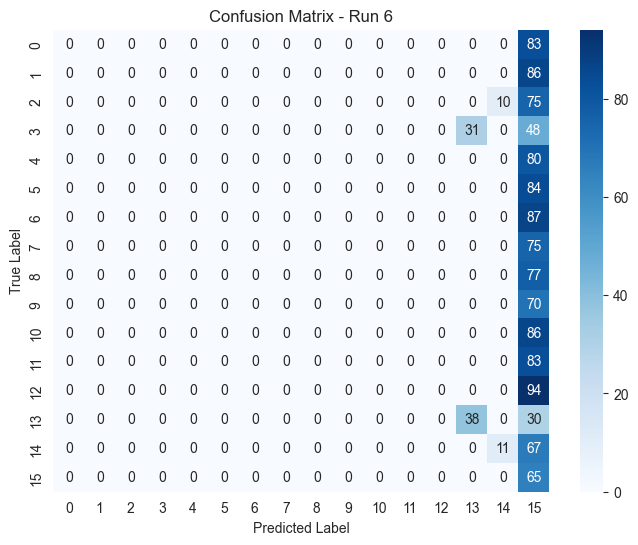

Number of correct predictions: 114
Number of incorrect predictions: 1166

******************************
Run 7
******************************

Training Accuracy: 0.9964
Validation Accuracy: 0.0638
Training Loss: 0.0118
Validation Loss: 7.4500


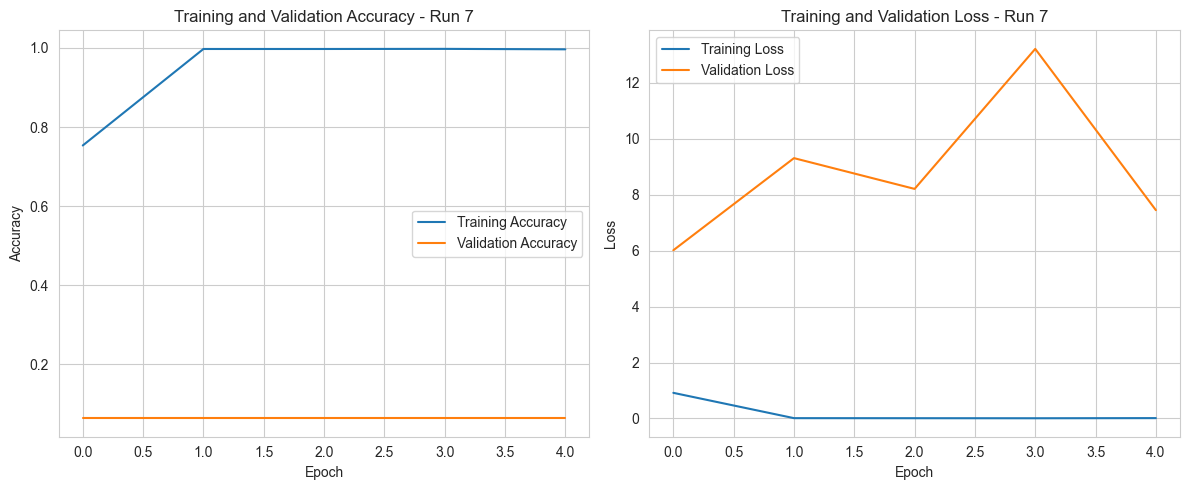

40/40 [==============================] - 1s 16ms/step


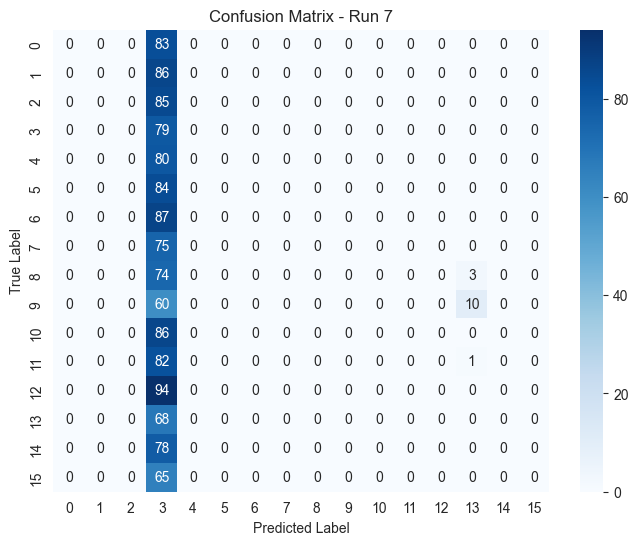

Number of correct predictions: 79
Number of incorrect predictions: 1201

******************************
Run 8
******************************

Training Accuracy: 1.0000
Validation Accuracy: 0.2357
Training Loss: 0.0009
Validation Loss: 3.7377


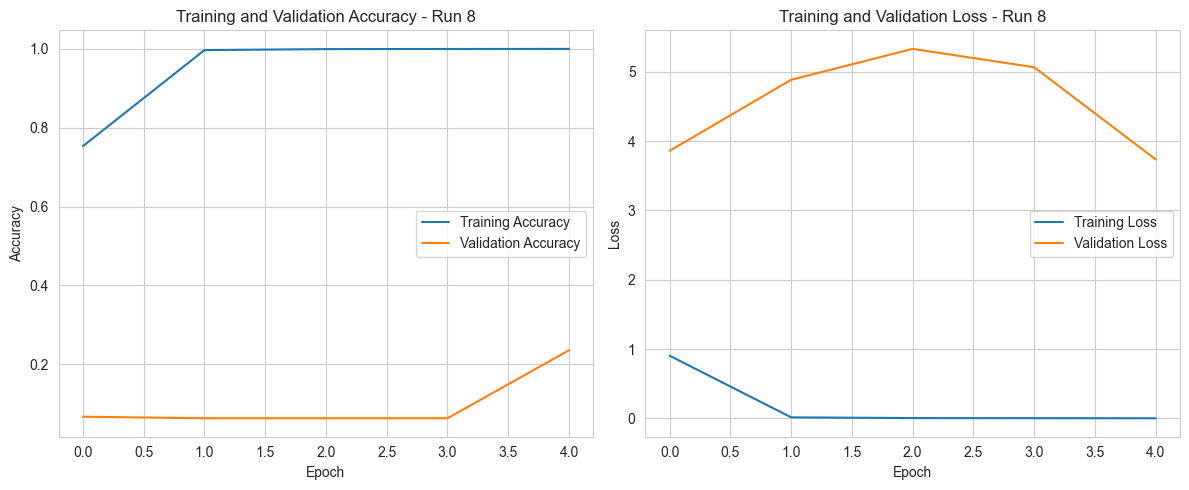

40/40 [==============================] - 1s 15ms/step


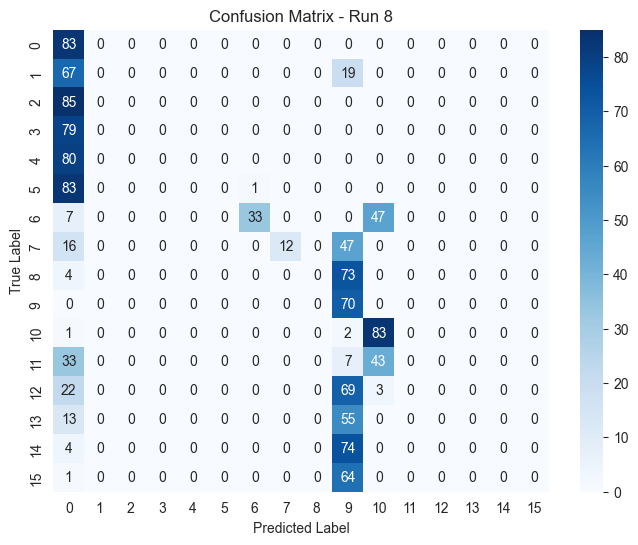

Number of correct predictions: 281
Number of incorrect predictions: 999

******************************
Run 9
******************************

Training Accuracy: 1.0000
Validation Accuracy: 0.1087
Training Loss: 0.0013
Validation Loss: 4.0231


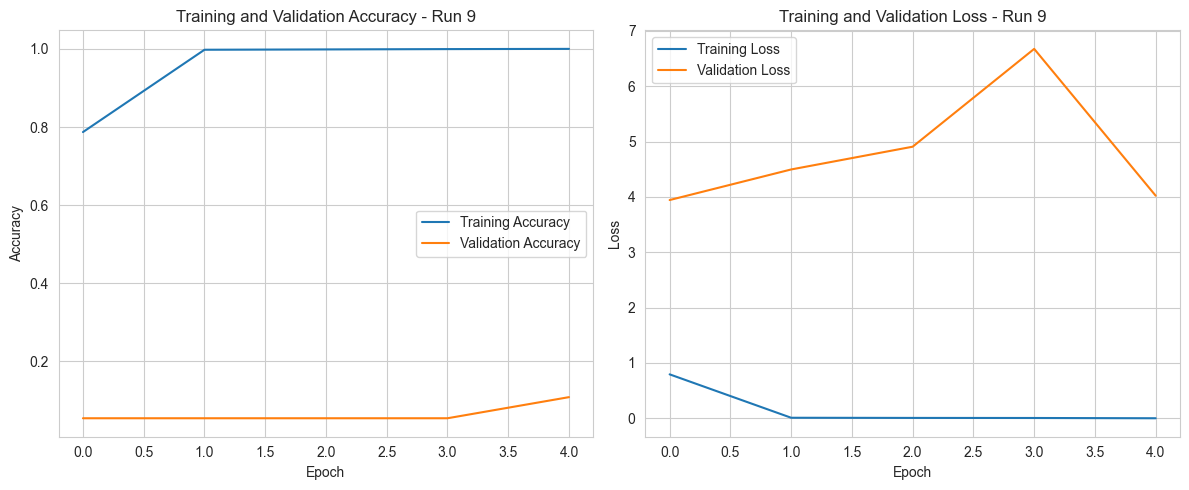

40/40 [==============================] - 1s 15ms/step


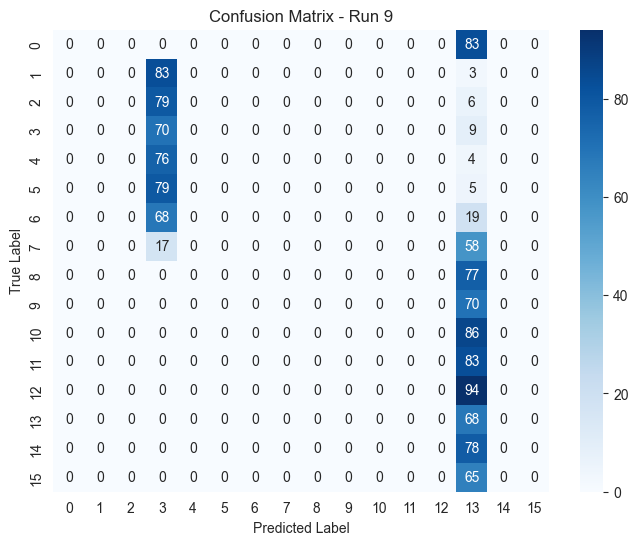

Number of correct predictions: 138
Number of incorrect predictions: 1142

******************************
Run 10
******************************

Training Accuracy: 0.9964
Validation Accuracy: 0.1237
Training Loss: 0.0128
Validation Loss: 4.9377


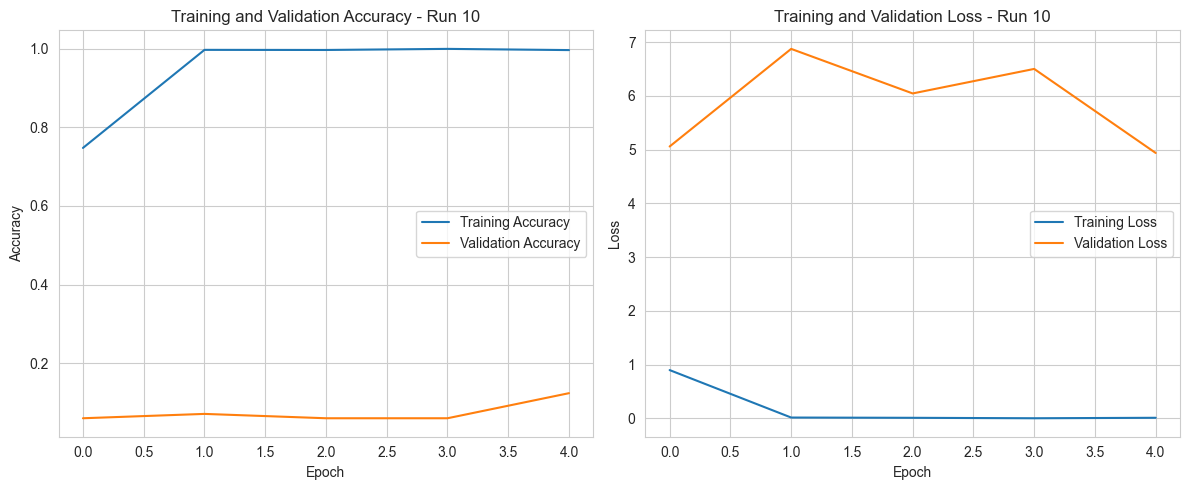

40/40 [==============================] - 1s 14ms/step


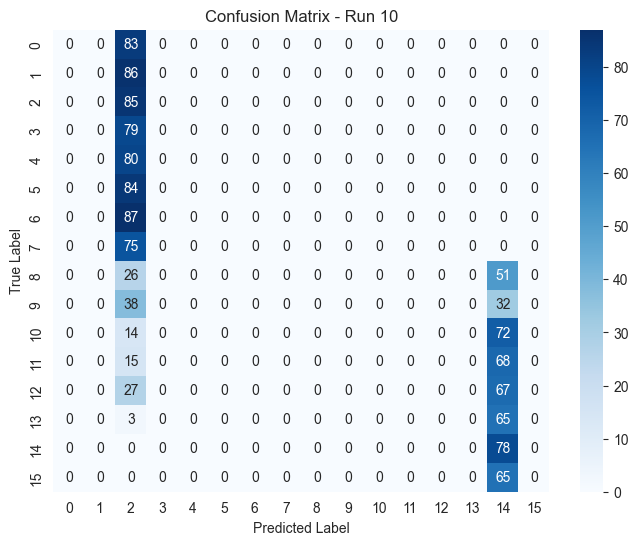

Number of correct predictions: 163
Number of incorrect predictions: 1117

Average number of correct predictions over 10 runs: 228.9
Standard deviation of correct predictions over 10 runs: 131.78122020986146


In [182]:
# Train and evaluate the model 10 times
num_epochs = 5
all_conf_matrices = []

for run in range(10):
    print("\n" + "*" * 30)
    print(f"Run {run + 1}")
    print("*" * 30)

    # Shuffle the training dataset
    indices = np.arange(train_data.shape[0])
    np.random.shuffle(indices)
    shuffled_train_data = train_data[indices]
    shuffled_train_targets = train_targets[indices]

    cnn_model_per_run = create_cnn_model(input_length, num_classes)
    history = cnn_model_per_run.fit(shuffled_train_data, shuffled_train_targets, epochs=num_epochs,
                                    validation_split=0.3, verbose=0)

    # Print the training and validation accuracy and loss
    training_accuracy = history.history['accuracy'][-1]
    validation_accuracy = history.history['val_accuracy'][-1]
    training_loss = history.history['loss'][-1]
    validation_loss = history.history['val_loss'][-1]

    print(f"\nTraining Accuracy: {training_accuracy:.4f}")
    print(f"Validation Accuracy: {validation_accuracy:.4f}")
    print(f"Training Loss: {training_loss:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}")

    # Plot the training and validation accuracy and loss
    plt.figure(figsize=(12, 5))

    # Plot the training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy - Run {run + 1}')
    plt.legend()

    # Plot the training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss - Run {run + 1}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    predicted_probabilities = cnn_model_per_run.predict(test_data)
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    conf_matrix = confusion_matrix(test_targets, predicted_labels)
    all_conf_matrices.append(conf_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_targets),
                yticklabels=np.unique(test_targets))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Run {run + 1}')
    plt.show()

    num_correct = np.sum(test_targets == predicted_labels)
    num_incorrect = len(test_targets) - num_correct
    print(f'Number of correct predictions: {num_correct}')
    print(f'Number of incorrect predictions: {num_incorrect}')

# Analyze the results
correct_predictions = [np.sum(np.diag(conf_matrix)) for conf_matrix in all_conf_matrices]
print(f"\nAverage number of correct predictions over 10 runs: {np.mean(correct_predictions)}")
print(f"Standard deviation of correct predictions over 10 runs: {np.std(correct_predictions)}")

## 5. Building and Evaluating the MLP Model
### 5.1 Shuffling the Dataset

In [191]:
# Shuffle the training dataset
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
train_data = train_data[indices]
train_targets = train_targets[indices]

### 5.2 Defining the MLP Architecture

In [192]:
# Define the MLP model
def build_mlp(input_length, num_classes):
    model = Sequential()
    # Input Layer and First Hidden Layer:
    model.add(Dense(512, activation='relu', input_shape=(input_length,)))

    # Dropout Layer:
    model.add(Dropout(0.5))

    # Output Layer:
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### 5.3 Reshaping the Dataset for MLP

In [193]:
# Reshape data to 2D for MLP
train_data_mlp = np.reshape(train_data, (train_data.shape[0], -1))
test_data_mlp = np.reshape(test_data, (test_data.shape[0], -1))

# Print the dataset shapes after reshaping
print("\nDataset shapes after reshaping for MLP:")
print("Training traces shape:", train_data_mlp.shape)
print("Test traces shape:", test_data_mlp.shape)


Dataset shapes after reshaping for MLP:
Training traces shape: (5120, 1000)
Test traces shape: (1280, 1000)


In [194]:
# Set input length and number of classes
input_length = train_data_mlp.shape[1]
num_classes = len(np.unique(train_targets))

# Print the input shape and number of classes
print(f"Input shape: ({input_length},)")
print(f"Number of classes: {num_classes}")

Input shape: (1000,)
Number of classes: 16


### 5.4 Training the MLP Model

In [195]:
mlp_model = build_mlp(input_length, num_classes)
mlp_model.summary()

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 512)               512512    
                                                                 
 dropout_137 (Dropout)       (None, 512)               0         
                                                                 
 dense_211 (Dense)           (None, 16)                8208      
                                                                 
Total params: 520720 (1.99 MB)
Trainable params: 520720 (1.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [196]:
# Train the MLP model
mlp_history = mlp_model.fit(train_data_mlp, train_targets, epochs=25, validation_split=0.3)

# Save the model
mlp_model.save('mlp_model.keras')

# Report the training and validation accuracy and loss
mlp_training_accuracy = mlp_history.history['accuracy'][-1]
mlp_validation_accuracy = mlp_history.history['val_accuracy'][-1]
mlp_training_loss = mlp_history.history['loss'][-1]
mlp_validation_loss = mlp_history.history['val_loss'][-1]

print(f"\nMLP Training Accuracy: {mlp_training_accuracy:.4f}")
print(f"MLP Validation Accuracy: {mlp_validation_accuracy:.4f}")
print(f"MLP Training Loss: {mlp_training_loss:.4f}")
print(f"MLP Validation Loss: {mlp_validation_loss:.4f}")

Epoch 1/25
112/112 [==============================] - 2s 9ms/step - loss: 1.8459 - accuracy: 0.6325 - val_loss: 0.8280 - val_accuracy: 0.9134
Epoch 2/25
112/112 [==============================] - 1s 8ms/step - loss: 0.4624 - accuracy: 0.9579 - val_loss: 0.2118 - val_accuracy: 0.9818
Epoch 3/25
112/112 [==============================] - 1s 8ms/step - loss: 0.1605 - accuracy: 0.9860 - val_loss: 0.0844 - val_accuracy: 0.9948
Epoch 4/25
112/112 [==============================] - 1s 7ms/step - loss: 0.0839 - accuracy: 0.9902 - val_loss: 0.0468 - val_accuracy: 0.9980
Epoch 5/25
112/112 [==============================] - 1s 7ms/step - loss: 0.0507 - accuracy: 0.9939 - val_loss: 0.0296 - val_accuracy: 0.9987
Epoch 6/25
112/112 [==============================] - 1s 7ms/step - loss: 0.0359 - accuracy: 0.9969 - val_loss: 0.0210 - val_accuracy: 0.9987
Epoch 7/25
112/112 [==============================] - 1s 7ms/step - loss: 0.0258 - accuracy: 0.9983 - val_loss: 0.0158 - val_accuracy: 0.9987
Epoch 

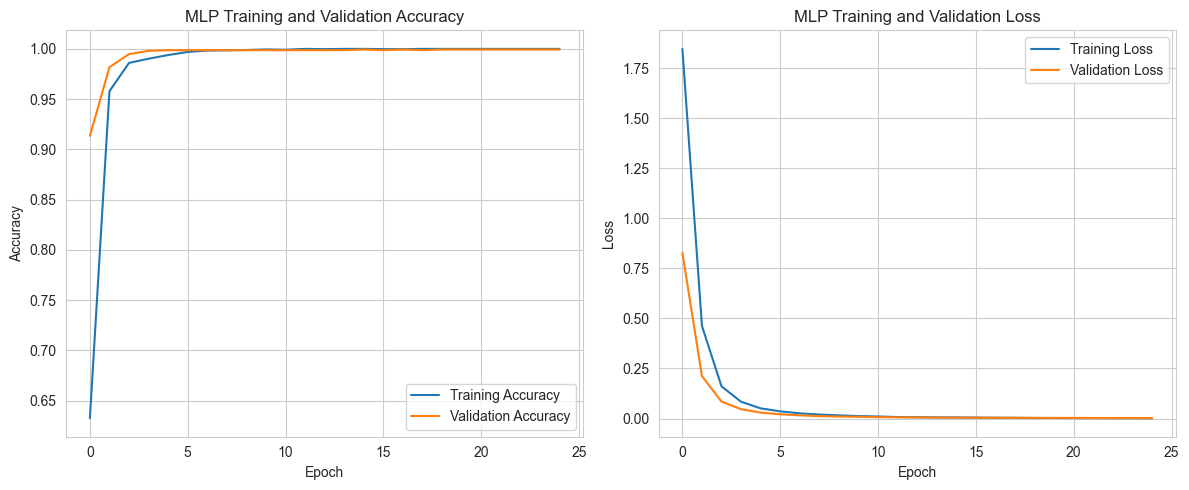

In [197]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot the training accuracy
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['accuracy'], label='Training Accuracy')
plt.plot(mlp_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP Training and Validation Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['loss'], label='Training Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 5.5 Evaluating the MLP Model

40/40 [==============================] - 0s 2ms/step


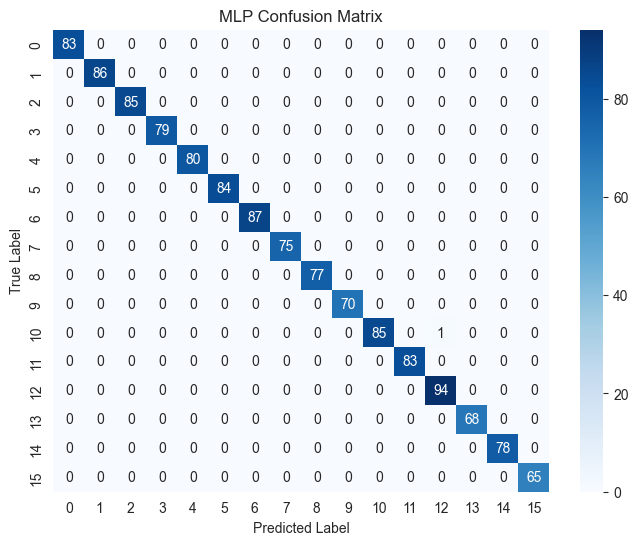

MLP Number of correct predictions: 1279
MLP Number of incorrect predictions: 1


In [198]:
# Predict the probabilities for the attack set using the MLP model
mlp_predicted_probabilities = mlp_model.predict(test_data_mlp)

# Convert the predicted probabilities to class labels
mlp_predicted_labels = np.argmax(mlp_predicted_probabilities, axis=1)

# Generate the confusion matrix for the MLP model
mlp_conf_matrix = confusion_matrix(test_targets, mlp_predicted_labels)

# Plot the confusion matrix for the MLP model
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_targets),
            yticklabels=np.unique(test_targets))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MLP Confusion Matrix')
plt.show()

# Print the number of correct and incorrect predictions for the MLP model
mlp_num_correct = np.sum(test_targets == mlp_predicted_labels)
mlp_num_incorrect = len(test_targets) - mlp_num_correct
print(f'MLP Number of correct predictions: {mlp_num_correct}')
print(f'MLP Number of incorrect predictions: {mlp_num_incorrect}')

### 5.6 Changing the Loss Function and Using One-Hot Encoding

In [199]:
# Replace the Loss Function and Use One-Hot Encoding
# Define the MLP model with categorical cross-entropy loss
def build_mlp_categorical(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [200]:
# Reshape data to 2D for MLP
train_data_mlp = np.reshape(train_data, (train_data.shape[0], -1))
test_data_mlp = np.reshape(test_data, (test_data.shape[0], -1))

# Print the dataset shapes after reshaping
print("\nDataset shapes after reshaping for MLP:")
print("Training traces shape:", train_data_mlp.shape)
print("Test traces shape:", test_data_mlp.shape)


Dataset shapes after reshaping for MLP:
Training traces shape: (5120, 1000)
Test traces shape: (1280, 1000)


In [201]:
# One-hot encode the labels
train_targets_ohe = to_categorical(train_targets, num_classes=num_classes)
test_targets_ohe = to_categorical(test_targets, num_classes=num_classes)

# Print the first 5 labels before and after one-hot encoding
print("Before one-hot encoding:")
print(train_targets[:5])
print("\nAfter one-hot encoding:")
print(train_targets_ohe[:5])

Before one-hot encoding:
[13 13  5  4  9]

After one-hot encoding:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [202]:
# Set input length and number of classes
input_length = train_data_mlp.shape[1]
num_classes = len(np.unique(train_targets))

# Print the input shape and number of classes
print(f"Input shape: ({input_length},)")
print(f"Number of classes: {num_classes}")

Input shape: (1000,)
Number of classes: 16


In [203]:
mlp_model_categorical = build_mlp_categorical(input_length, num_classes)
mlp_model_categorical.summary()

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_212 (Dense)           (None, 512)               512512    
                                                                 
 dropout_138 (Dropout)       (None, 512)               0         
                                                                 
 dense_213 (Dense)           (None, 16)                8208      
                                                                 
Total params: 520720 (1.99 MB)
Trainable params: 520720 (1.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [204]:
# Train the MLP model
mlp_history_categorical = mlp_model_categorical.fit(train_data_mlp, train_targets_ohe, epochs=25, validation_split=0.3)

# Save the model
mlp_model_categorical.save('mlp_model_categorical.keras')

# Report the training and validation accuracy and loss
mlp_training_accuracy_categorical = mlp_history_categorical.history['accuracy'][-1]
mlp_validation_accuracy_categorical = mlp_history_categorical.history['val_accuracy'][-1]
mlp_training_loss_categorical = mlp_history_categorical.history['loss'][-1]
mlp_validation_loss_categorical = mlp_history_categorical.history['val_loss'][-1]

print(f"\nMLP (Categorical) Training Accuracy: {mlp_training_accuracy_categorical:.4f}")
print(f"MLP (Categorical) Validation Accuracy: {mlp_validation_accuracy_categorical:.4f}")
print(f"MLP (Categorical) Training Loss: {mlp_training_loss_categorical:.4f}")
print(f"MLP (Categorical) Validation Loss: {mlp_validation_loss_categorical:.4f}")

Epoch 1/25
112/112 [==============================] - 2s 9ms/step - loss: 1.8240 - accuracy: 0.6191 - val_loss: 0.8075 - val_accuracy: 0.9499
Epoch 2/25
112/112 [==============================] - 1s 7ms/step - loss: 0.4606 - accuracy: 0.9593 - val_loss: 0.2049 - val_accuracy: 0.9850
Epoch 3/25
112/112 [==============================] - 1s 7ms/step - loss: 0.1589 - accuracy: 0.9855 - val_loss: 0.0839 - val_accuracy: 0.9967
Epoch 4/25
112/112 [==============================] - 1s 7ms/step - loss: 0.0830 - accuracy: 0.9922 - val_loss: 0.0456 - val_accuracy: 0.9980
Epoch 5/25
112/112 [==============================] - 1s 8ms/step - loss: 0.0508 - accuracy: 0.9955 - val_loss: 0.0292 - val_accuracy: 0.9980
Epoch 6/25
112/112 [==============================] - 1s 8ms/step - loss: 0.0351 - accuracy: 0.9967 - val_loss: 0.0211 - val_accuracy: 0.9980
Epoch 7/25
112/112 [==============================] - 1s 8ms/step - loss: 0.0268 - accuracy: 0.9978 - val_loss: 0.0162 - val_accuracy: 0.9987
Epoch 

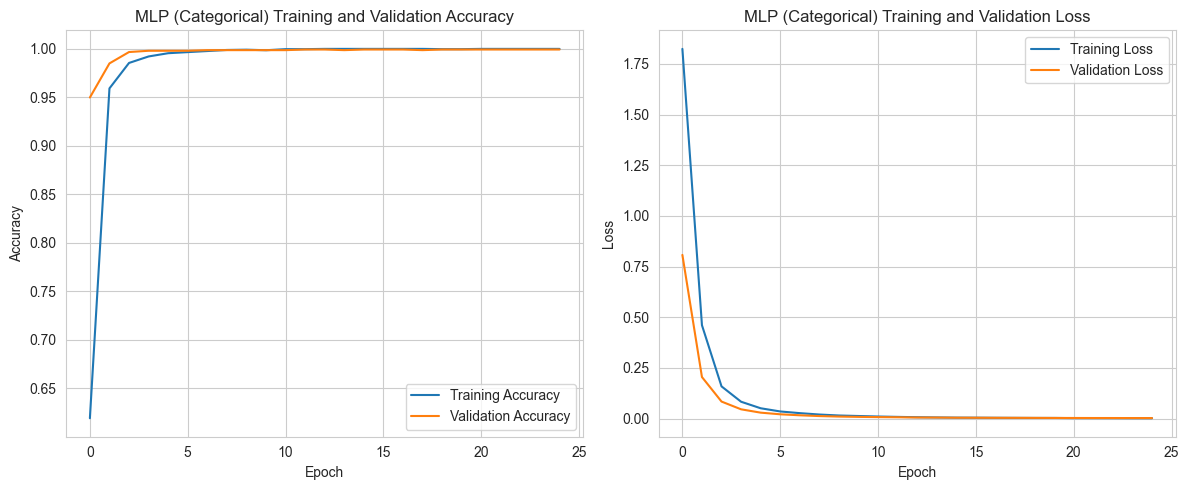

In [205]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot the training accuracy
plt.subplot(1, 2, 1)
plt.plot(mlp_history_categorical.history['accuracy'], label='Training Accuracy')
plt.plot(mlp_history_categorical.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP (Categorical) Training and Validation Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(mlp_history_categorical.history['loss'], label='Training Loss')
plt.plot(mlp_history_categorical.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP (Categorical) Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 5.7 Evaluating the MLP Model with Categorical Cross-Entropy

40/40 [==============================] - 0s 2ms/step


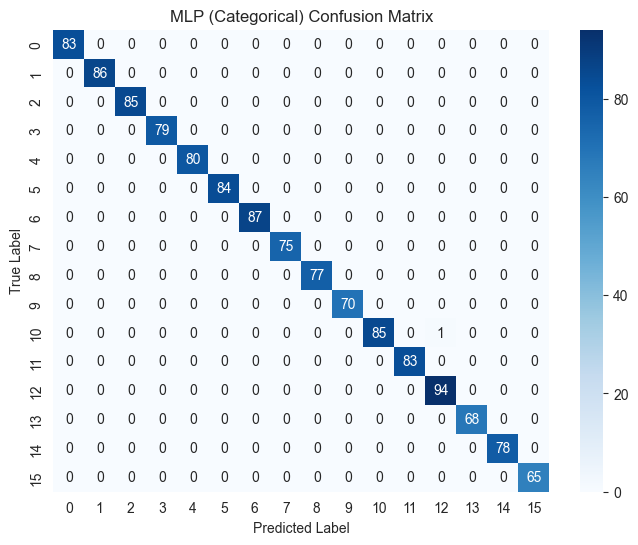

MLP (Categorical) Number of correct predictions: 1279
MLP (Categorical) Number of incorrect predictions: 1


In [206]:
# Predict the probabilities for the attack set using the MLP model
mlp_predicted_probabilities_categorical = mlp_model_categorical.predict(test_data_mlp)

# Convert the predicted probabilities to class labels
mlp_predicted_labels_categorical = np.argmax(mlp_predicted_probabilities_categorical, axis=1)

# Generate the confusion matrix for the MLP model
mlp_conf_matrix_categorical = confusion_matrix(test_targets, mlp_predicted_labels_categorical)

# Plot the confusion matrix for the MLP model
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_conf_matrix_categorical, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_targets),
            yticklabels=np.unique(test_targets))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MLP (Categorical) Confusion Matrix')
plt.show()

# Print the number of correct and incorrect predictions for the MLP model
mlp_num_correct_categorical = np.sum(test_targets == mlp_predicted_labels_categorical)
mlp_num_incorrect_categorical = len(test_targets) - mlp_num_correct_categorical
print(f'MLP (Categorical) Number of correct predictions: {mlp_num_correct_categorical}')
print(f'MLP (Categorical) Number of incorrect predictions: {mlp_num_incorrect_categorical}')

## 6. Investigating the Impact of Training Hyperparameters
### 6.1 Evaluating Different Learning Rates

In [211]:
# Changing the lr
# Define the MLP model with modified learning rate
def build_mlp_with_lr(input_shape, num_classes, learning_rate):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


****************************************
Testing with learning rate: 1e-07
****************************************
MLP (LR=1e-07) Training Accuracy: 0.0731
MLP (LR=1e-07) Validation Accuracy: 0.0801
MLP (LR=1e-07) Training Loss: 2.7702
MLP (LR=1e-07) Validation Loss: 2.7695


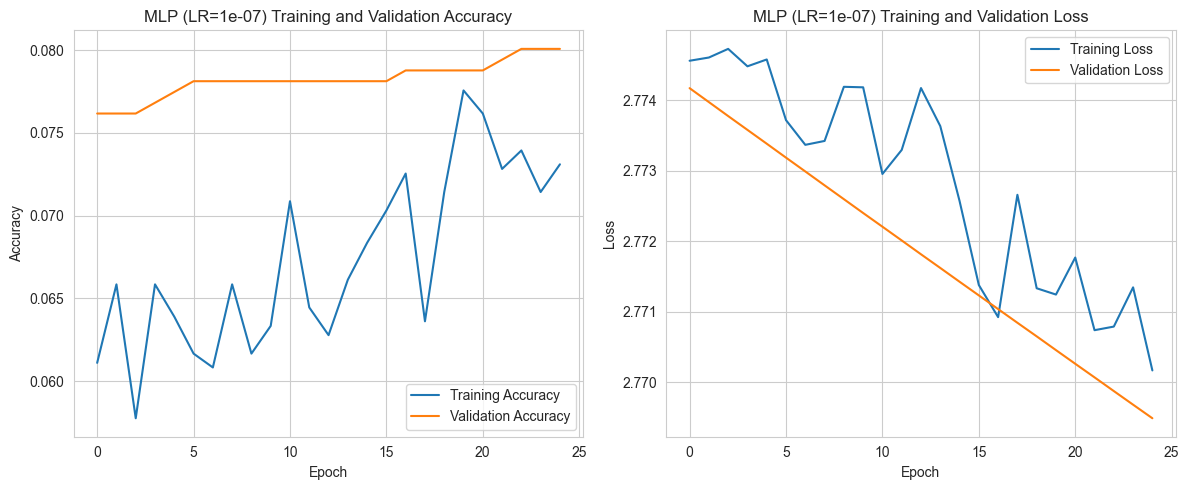

40/40 [==============================] - 0s 2ms/step


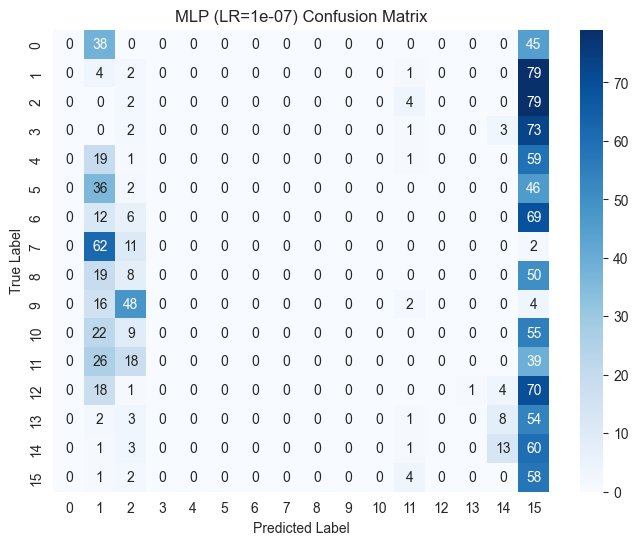

MLP (LR=1e-07) Number of correct predictions: 77
MLP (LR=1e-07) Number of incorrect predictions: 1203

****************************************
Testing with learning rate: 1e-06
****************************************
MLP (LR=1e-06) Training Accuracy: 0.2832
MLP (LR=1e-06) Validation Accuracy: 0.4284
MLP (LR=1e-06) Training Loss: 2.7234
MLP (LR=1e-06) Validation Loss: 2.7238


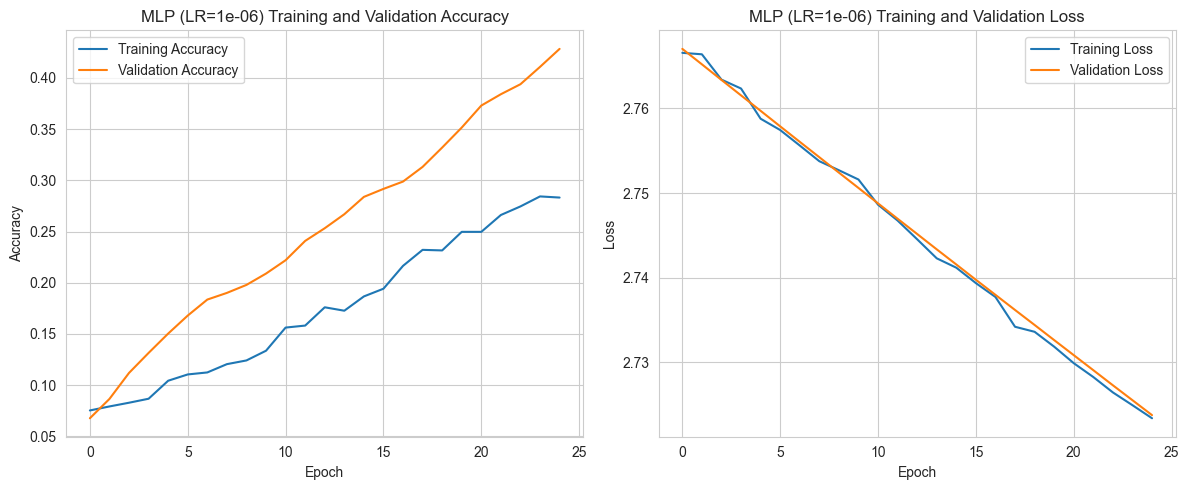

40/40 [==============================] - 0s 3ms/step


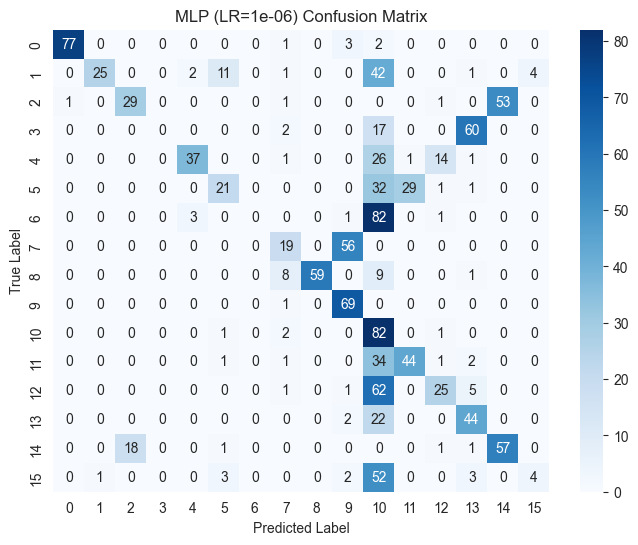

MLP (LR=1e-06) Number of correct predictions: 592
MLP (LR=1e-06) Number of incorrect predictions: 688

****************************************
Testing with learning rate: 1e-05
****************************************
MLP (LR=1e-05) Training Accuracy: 0.8072
MLP (LR=1e-05) Validation Accuracy: 0.9108
MLP (LR=1e-05) Training Loss: 2.1726
MLP (LR=1e-05) Validation Loss: 2.1637


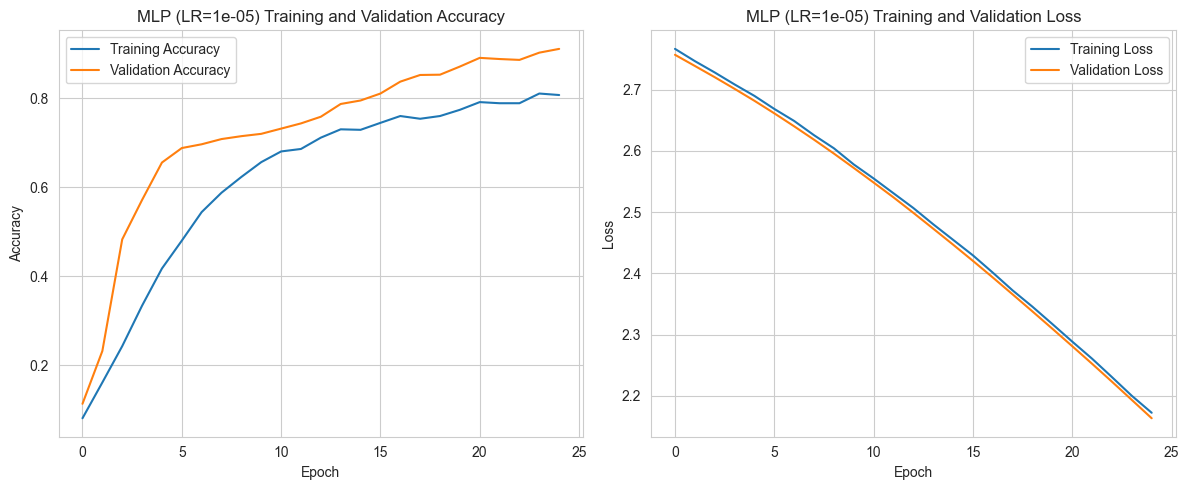

40/40 [==============================] - 0s 2ms/step


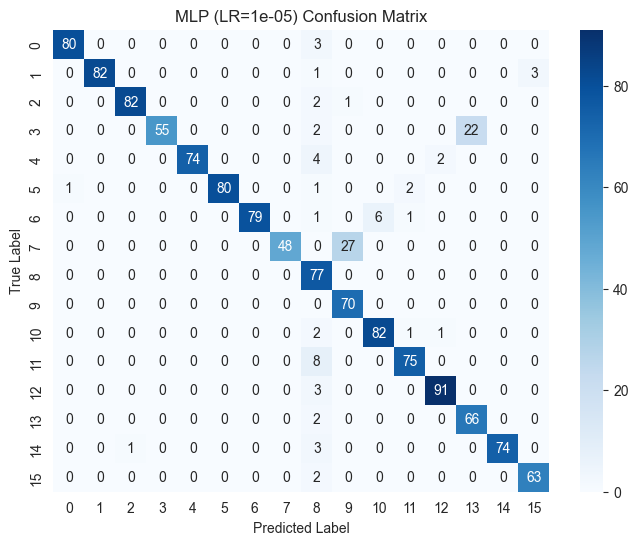

MLP (LR=1e-05) Number of correct predictions: 1178
MLP (LR=1e-05) Number of incorrect predictions: 102

****************************************
Testing with learning rate: 0.0001
****************************************
MLP (LR=0.0001) Training Accuracy: 0.9939
MLP (LR=0.0001) Validation Accuracy: 0.9967
MLP (LR=0.0001) Training Loss: 0.0865
MLP (LR=0.0001) Validation Loss: 0.0678


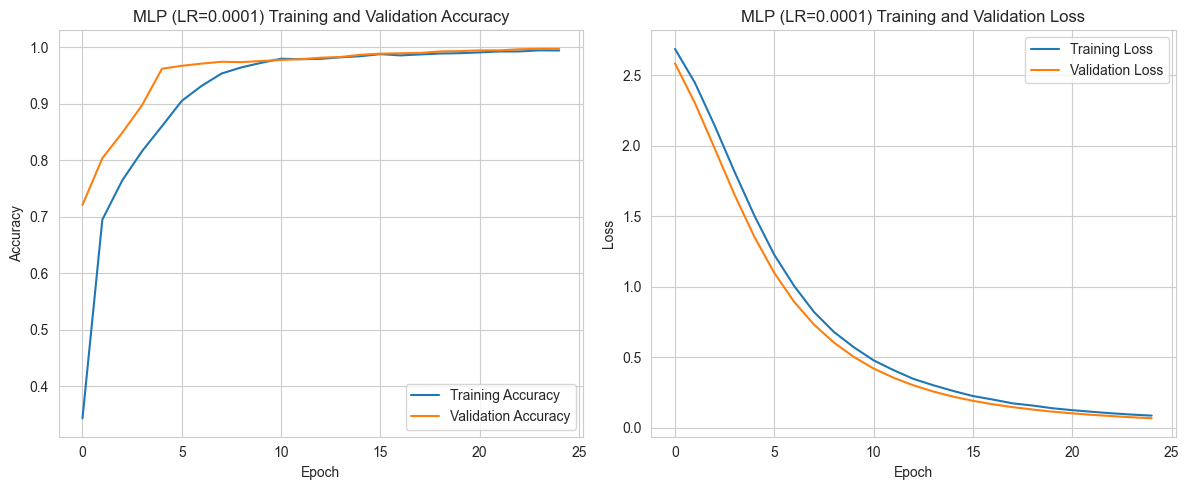

40/40 [==============================] - 0s 2ms/step


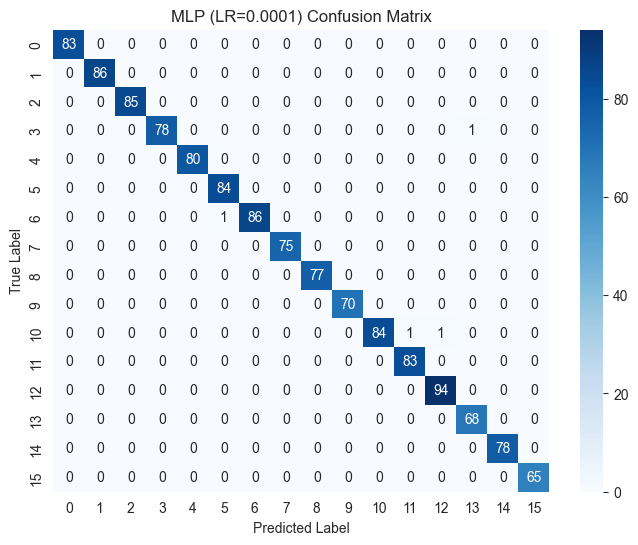

MLP (LR=0.0001) Number of correct predictions: 1276
MLP (LR=0.0001) Number of incorrect predictions: 4

****************************************
Testing with learning rate: 0.001
****************************************
MLP (LR=0.001) Training Accuracy: 1.0000
MLP (LR=0.001) Validation Accuracy: 0.9993
MLP (LR=0.001) Training Loss: 0.0014
MLP (LR=0.001) Validation Loss: 0.0025


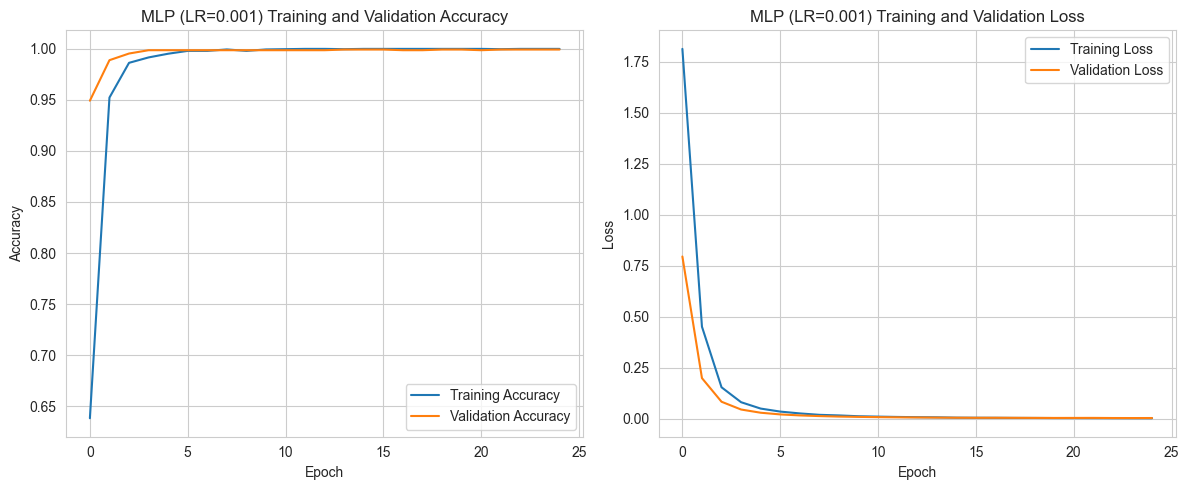

40/40 [==============================] - 0s 2ms/step


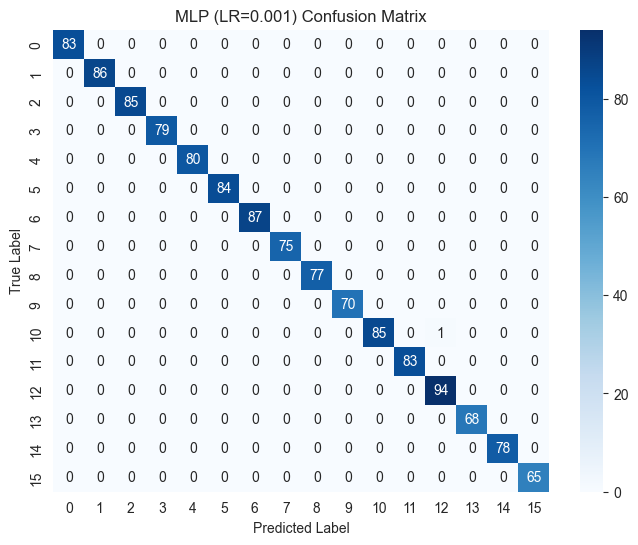

MLP (LR=0.001) Number of correct predictions: 1279
MLP (LR=0.001) Number of incorrect predictions: 1

****************************************
Testing with learning rate: 0.01
****************************************
MLP (LR=0.01) Training Accuracy: 0.9916
MLP (LR=0.01) Validation Accuracy: 0.9993
MLP (LR=0.01) Training Loss: 0.0502
MLP (LR=0.01) Validation Loss: 0.0043


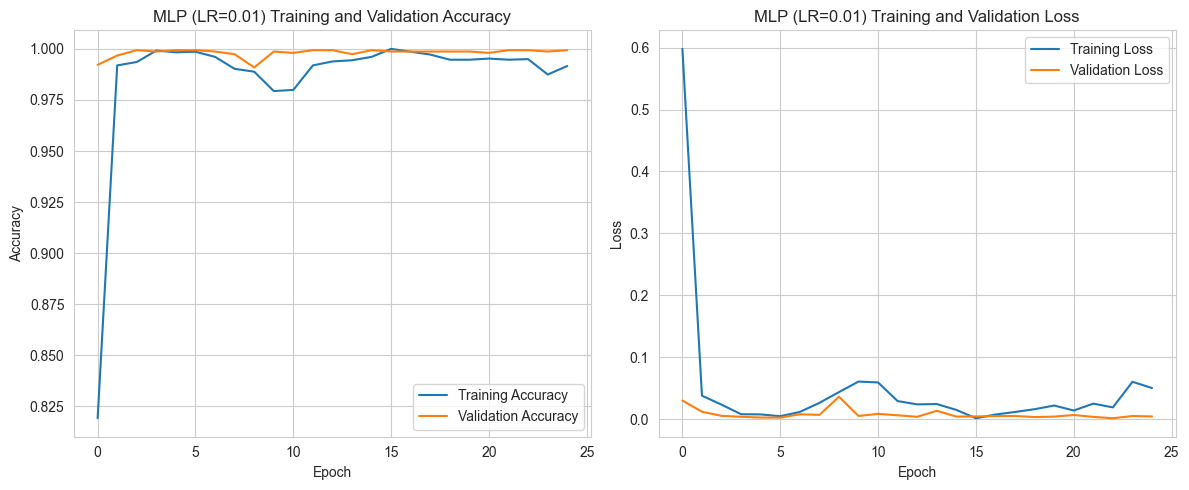

40/40 [==============================] - 0s 2ms/step


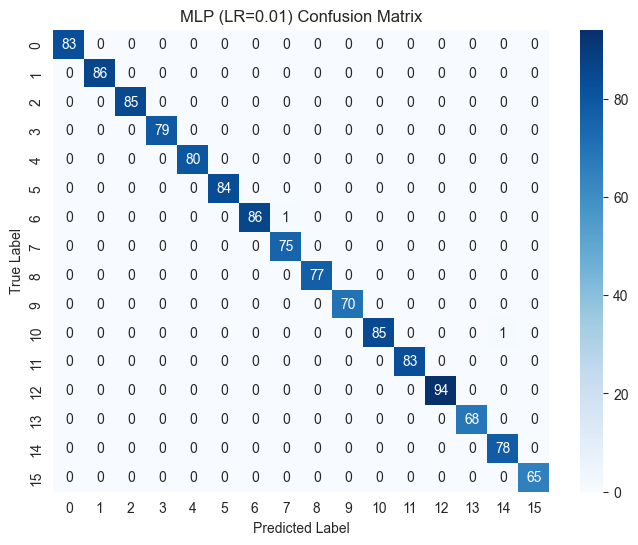

MLP (LR=0.01) Number of correct predictions: 1278
MLP (LR=0.01) Number of incorrect predictions: 2

****************************************
Testing with learning rate: 0.1
****************************************
MLP (LR=0.1) Training Accuracy: 0.1638
MLP (LR=0.1) Validation Accuracy: 0.2318
MLP (LR=0.1) Training Loss: 2.4822
MLP (LR=0.1) Validation Loss: 2.2303


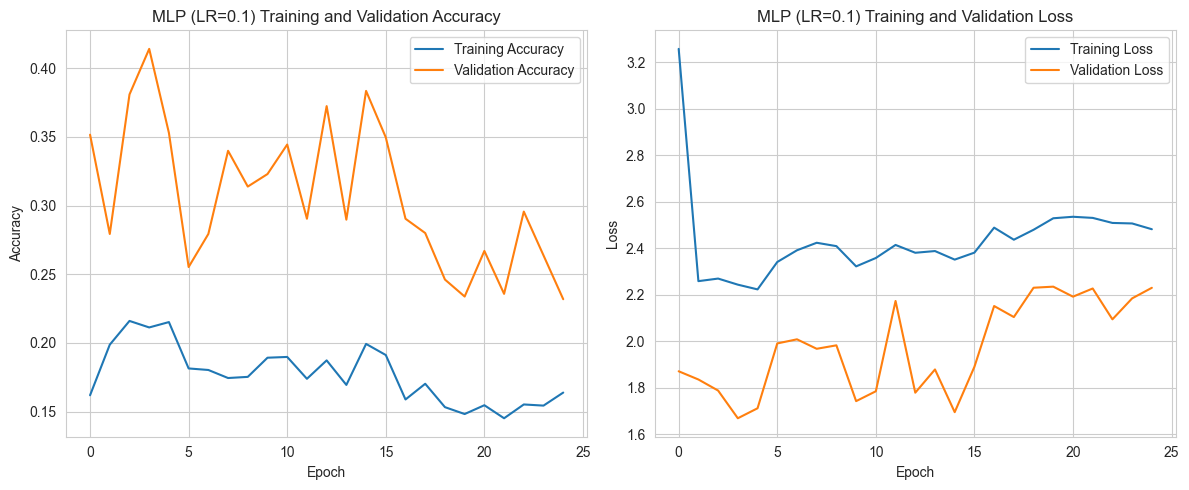

40/40 [==============================] - 0s 2ms/step


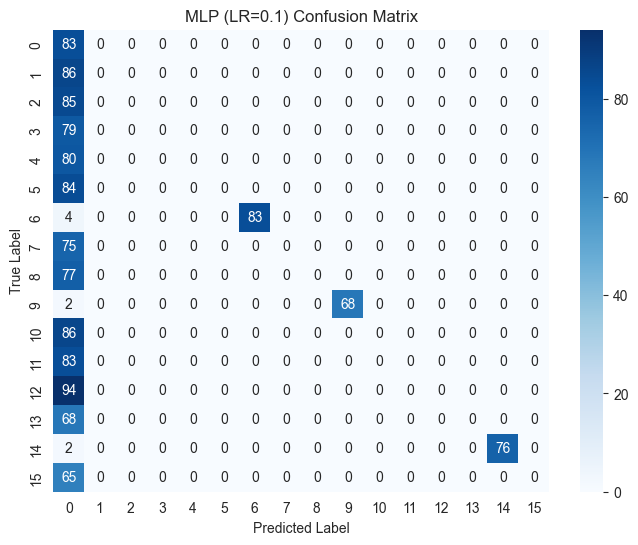

MLP (LR=0.1) Number of correct predictions: 310
MLP (LR=0.1) Number of incorrect predictions: 970

****************************************
Testing with learning rate: 1
****************************************
MLP (LR=1) Training Accuracy: 0.0578
MLP (LR=1) Validation Accuracy: 0.0612
MLP (LR=1) Training Loss: 2.9086
MLP (LR=1) Validation Loss: 2.9188


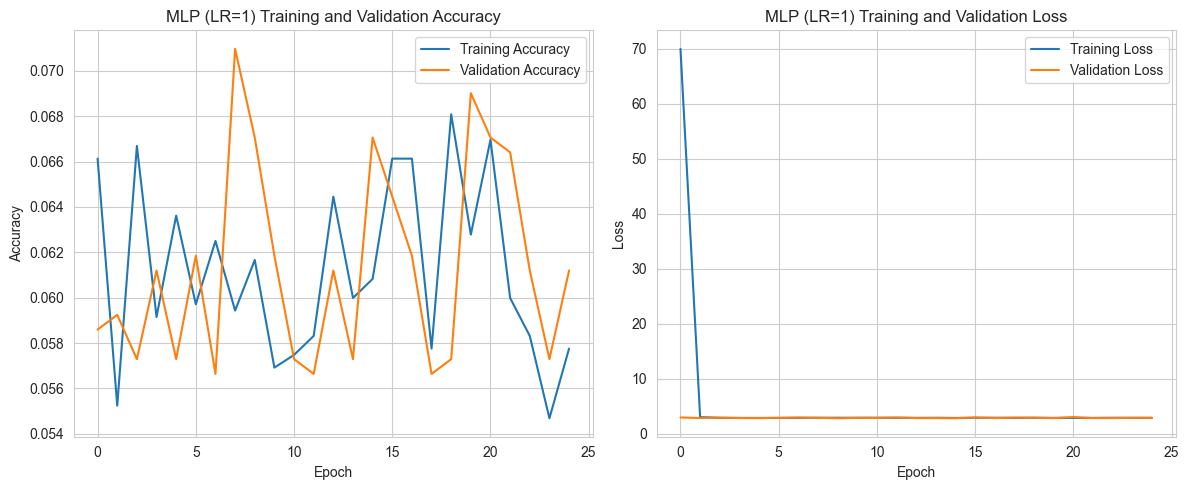

40/40 [==============================] - 0s 2ms/step


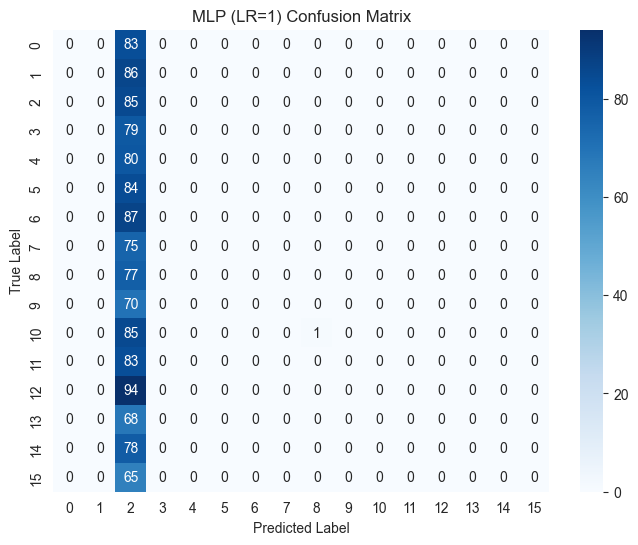

MLP (LR=1) Number of correct predictions: 85
MLP (LR=1) Number of incorrect predictions: 1195


In [212]:
# Different learning rates to test
learning_rates = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

for lr in learning_rates:
    print("\n" + "*" * 40)
    print(f"Testing with learning rate: {lr}")
    print("*" * 40)
    mlp_model_lr = build_mlp_with_lr(train_data_mlp.shape[1], len(np.unique(train_targets)), lr)
    mlp_history_lr = mlp_model_lr.fit(train_data_mlp, train_targets, epochs=25, validation_split=0.3, verbose=0)

    # Report the training and validation accuracy and loss
    mlp_training_accuracy_lr = mlp_history_lr.history['accuracy'][-1]
    mlp_validation_accuracy_lr = mlp_history_lr.history['val_accuracy'][-1]
    mlp_training_loss_lr = mlp_history_lr.history['loss'][-1]
    mlp_validation_loss_lr = mlp_history_lr.history['val_loss'][-1]

    print(f"MLP (LR={lr}) Training Accuracy: {mlp_training_accuracy_lr:.4f}")
    print(f"MLP (LR={lr}) Validation Accuracy: {mlp_validation_accuracy_lr:.4f}")
    print(f"MLP (LR={lr}) Training Loss: {mlp_training_loss_lr:.4f}")
    print(f"MLP (LR={lr}) Validation Loss: {mlp_validation_loss_lr:.4f}")

    # Plot the training and validation accuracy and loss
    plt.figure(figsize=(12, 5))

    # Plot the training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(mlp_history_lr.history['accuracy'], label='Training Accuracy')
    plt.plot(mlp_history_lr.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'MLP (LR={lr}) Training and Validation Accuracy')
    plt.legend()

    # Plot the training loss
    plt.subplot(1, 2, 2)
    plt.plot(mlp_history_lr.history['loss'], label='Training Loss')
    plt.plot(mlp_history_lr.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'MLP (LR={lr}) Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Predict the probabilities for the attack set using the MLP model
    mlp_predicted_probabilities_lr = mlp_model_lr.predict(test_data_mlp)

    # Convert the predicted probabilities to class labels
    mlp_predicted_labels_lr = np.argmax(mlp_predicted_probabilities_lr, axis=1)

    # Generate the confusion matrix for the MLP model
    mlp_conf_matrix_lr = confusion_matrix(test_targets, mlp_predicted_labels_lr)

    # Plot the confusion matrix for the MLP model
    plt.figure(figsize=(8, 6))
    sns.heatmap(mlp_conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_targets),
                yticklabels=np.unique(test_targets))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'MLP (LR={lr}) Confusion Matrix')
    plt.show()

    # Print the number of correct and incorrect predictions for the MLP model
    mlp_num_correct_lr = np.sum(test_targets == mlp_predicted_labels_lr)
    mlp_num_incorrect_lr = len(test_targets) - mlp_num_correct_lr
    print(f'MLP (LR={lr}) Number of correct predictions: {mlp_num_correct_lr}')
    print(f'MLP (LR={lr}) Number of incorrect predictions: {mlp_num_incorrect_lr}')

### 6.2 Adjusting the Number of Neurons

In [213]:
# Changing the number of neurons

# Define the MLP model with different number of neurons
def build_mlp_with_neurons(input_shape, num_classes, num_neurons):
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


****************************************
Testing with 2 neurons
****************************************
MLP (2 Neurons) Training Accuracy: 0.1097
MLP (2 Neurons) Validation Accuracy: 0.1888
MLP (2 Neurons) Training Loss: 2.5331
MLP (2 Neurons) Validation Loss: 2.3180


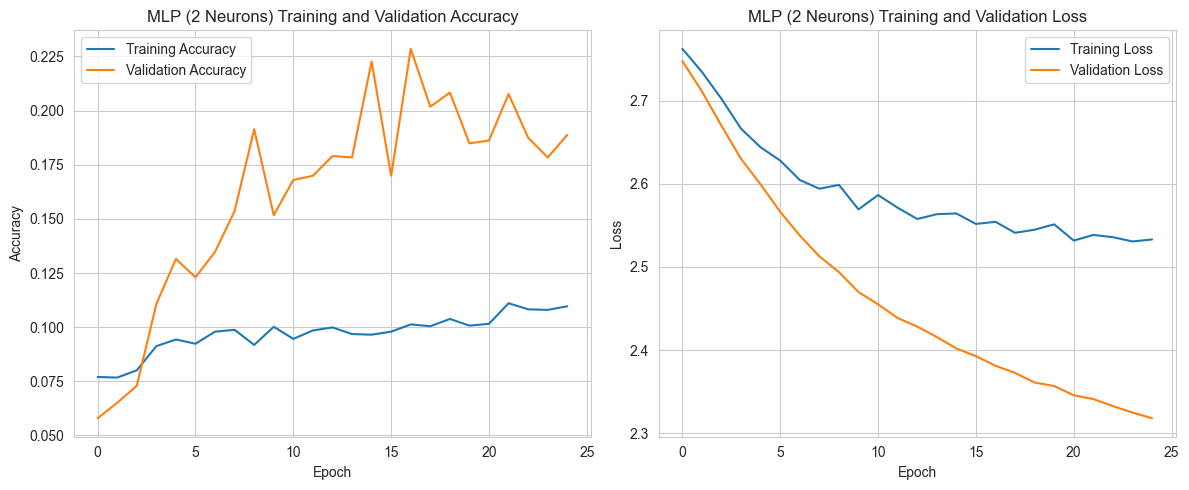

40/40 [==============================] - 0s 1ms/step


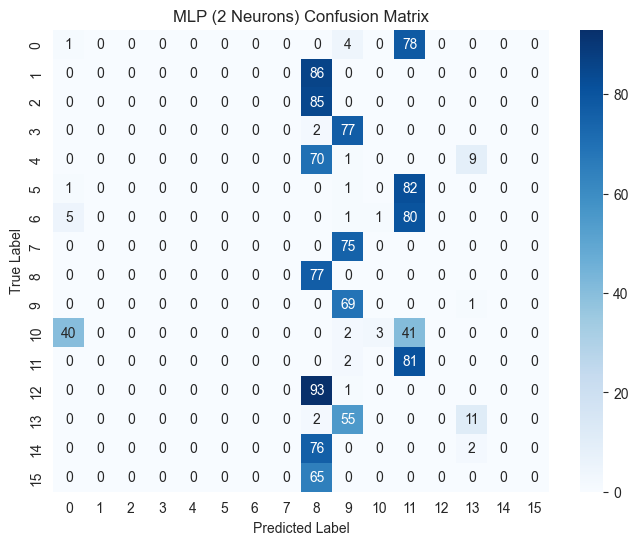

MLP (2 Neurons) Number of correct predictions: 242
MLP (2 Neurons) Number of incorrect predictions: 1038

****************************************
Testing with 4 neurons
****************************************
MLP (4 Neurons) Training Accuracy: 0.2012
MLP (4 Neurons) Validation Accuracy: 0.5723
MLP (4 Neurons) Training Loss: 2.0881
MLP (4 Neurons) Validation Loss: 1.5393


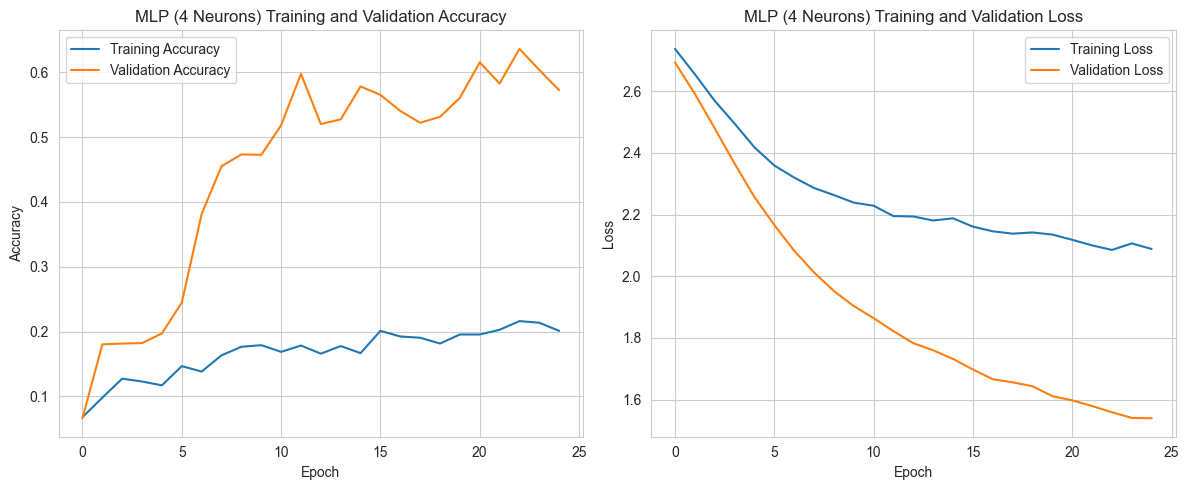

40/40 [==============================] - 0s 1ms/step


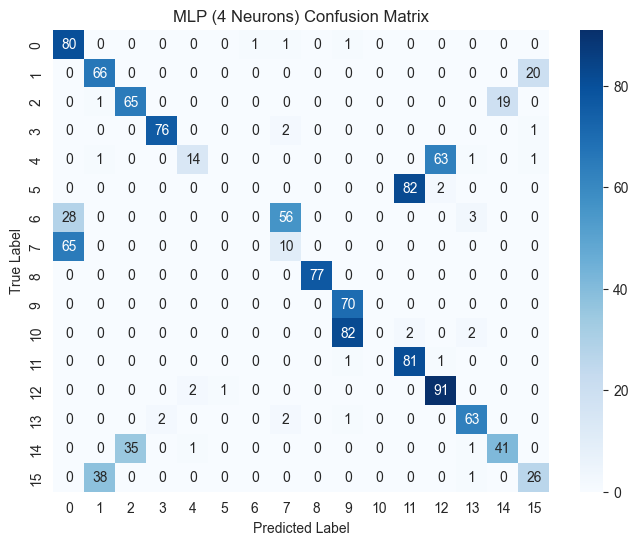

MLP (4 Neurons) Number of correct predictions: 760
MLP (4 Neurons) Number of incorrect predictions: 520

****************************************
Testing with 16 neurons
****************************************
MLP (16 Neurons) Training Accuracy: 0.6027
MLP (16 Neurons) Validation Accuracy: 0.9935
MLP (16 Neurons) Training Loss: 0.9968
MLP (16 Neurons) Validation Loss: 0.2066


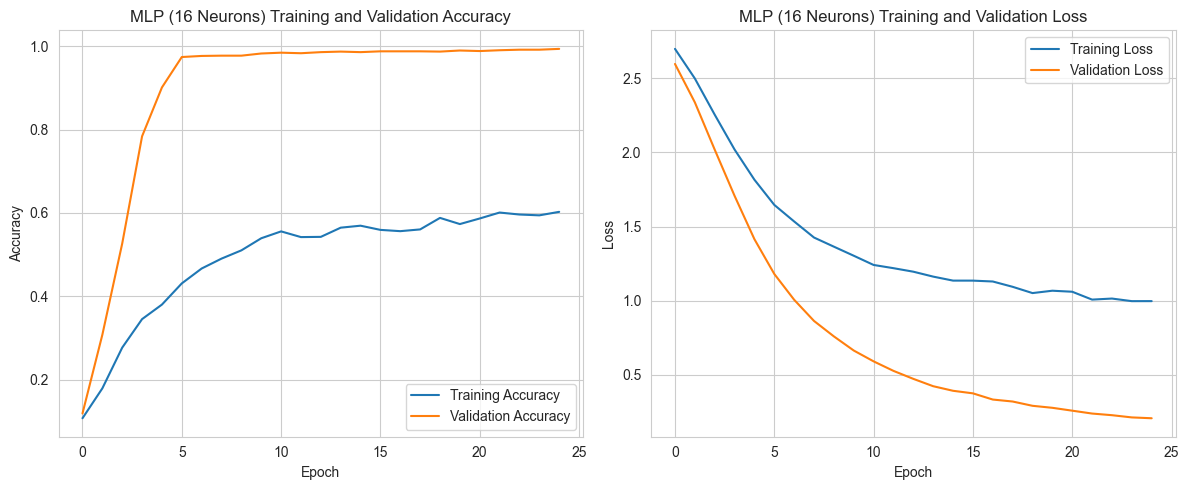

40/40 [==============================] - 0s 2ms/step


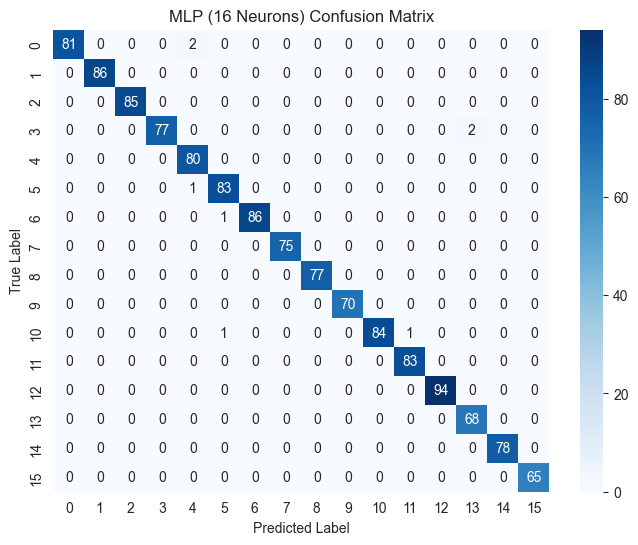

MLP (16 Neurons) Number of correct predictions: 1272
MLP (16 Neurons) Number of incorrect predictions: 8

****************************************
Testing with 32 neurons
****************************************
MLP (32 Neurons) Training Accuracy: 0.9163
MLP (32 Neurons) Validation Accuracy: 0.9987
MLP (32 Neurons) Training Loss: 0.2634
MLP (32 Neurons) Validation Loss: 0.0203


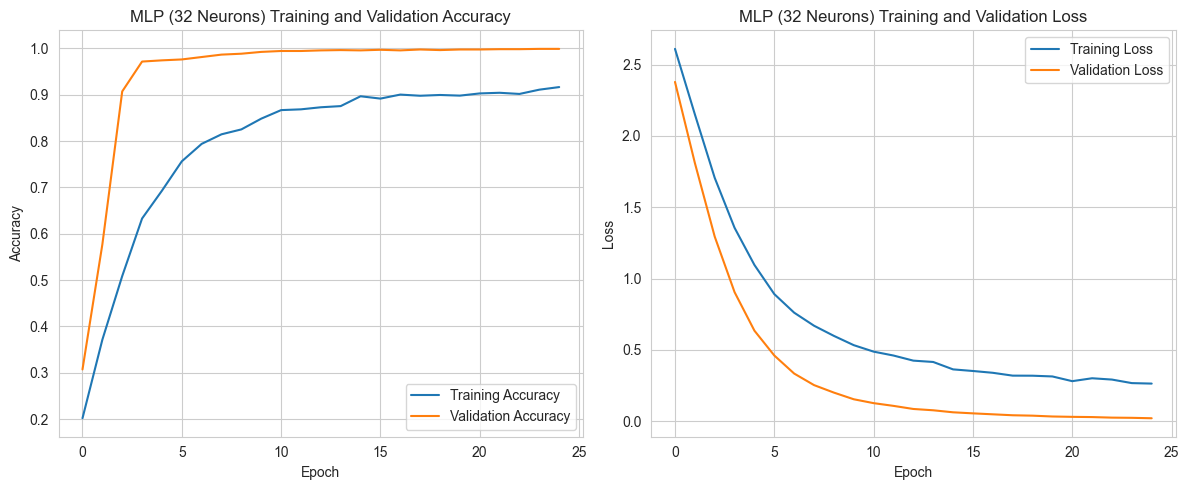

40/40 [==============================] - 0s 1ms/step


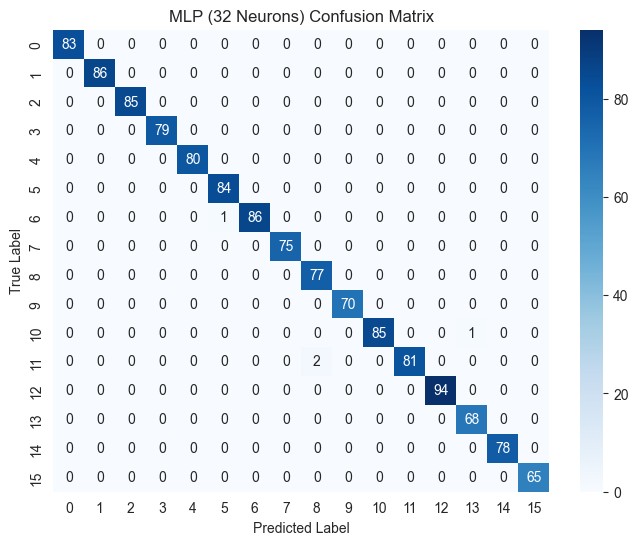

MLP (32 Neurons) Number of correct predictions: 1276
MLP (32 Neurons) Number of incorrect predictions: 4

****************************************
Testing with 64 neurons
****************************************
MLP (64 Neurons) Training Accuracy: 0.9877
MLP (64 Neurons) Validation Accuracy: 0.9987
MLP (64 Neurons) Training Loss: 0.0650
MLP (64 Neurons) Validation Loss: 0.0078


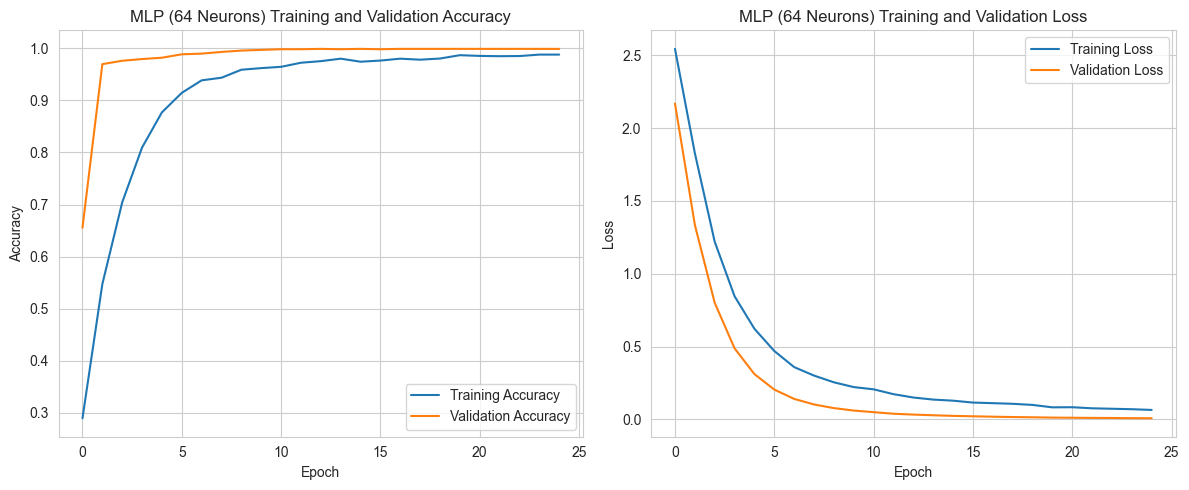

40/40 [==============================] - 0s 2ms/step


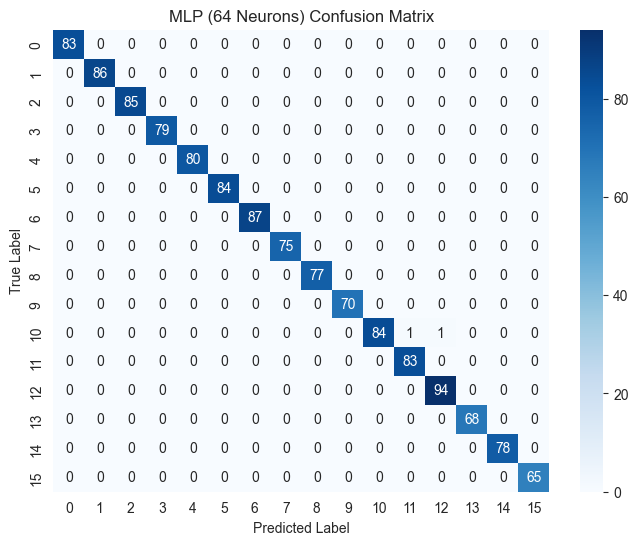

MLP (64 Neurons) Number of correct predictions: 1278
MLP (64 Neurons) Number of incorrect predictions: 2

****************************************
Testing with 128 neurons
****************************************
MLP (128 Neurons) Training Accuracy: 0.9994
MLP (128 Neurons) Validation Accuracy: 0.9993
MLP (128 Neurons) Training Loss: 0.0114
MLP (128 Neurons) Validation Loss: 0.0039


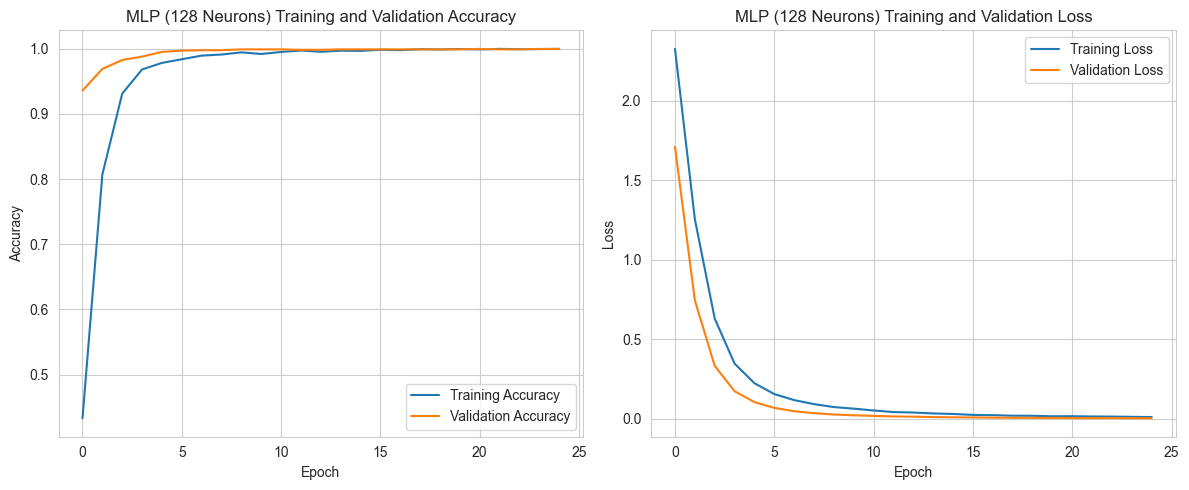

40/40 [==============================] - 0s 2ms/step


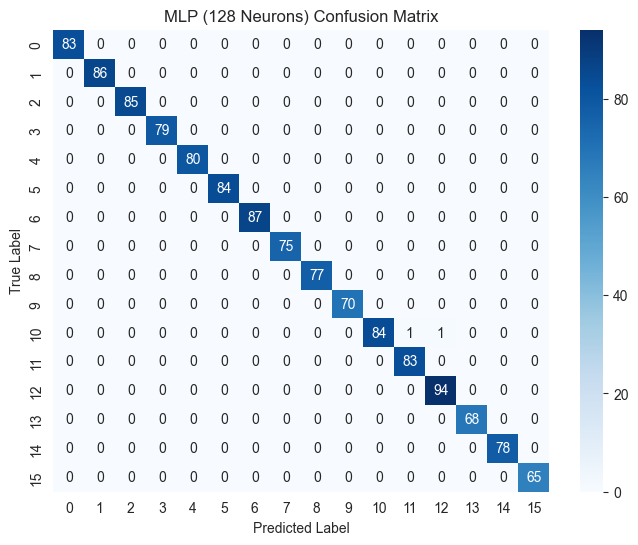

MLP (128 Neurons) Number of correct predictions: 1278
MLP (128 Neurons) Number of incorrect predictions: 2

****************************************
Testing with 256 neurons
****************************************
MLP (256 Neurons) Training Accuracy: 1.0000
MLP (256 Neurons) Validation Accuracy: 0.9993
MLP (256 Neurons) Training Loss: 0.0040
MLP (256 Neurons) Validation Loss: 0.0028


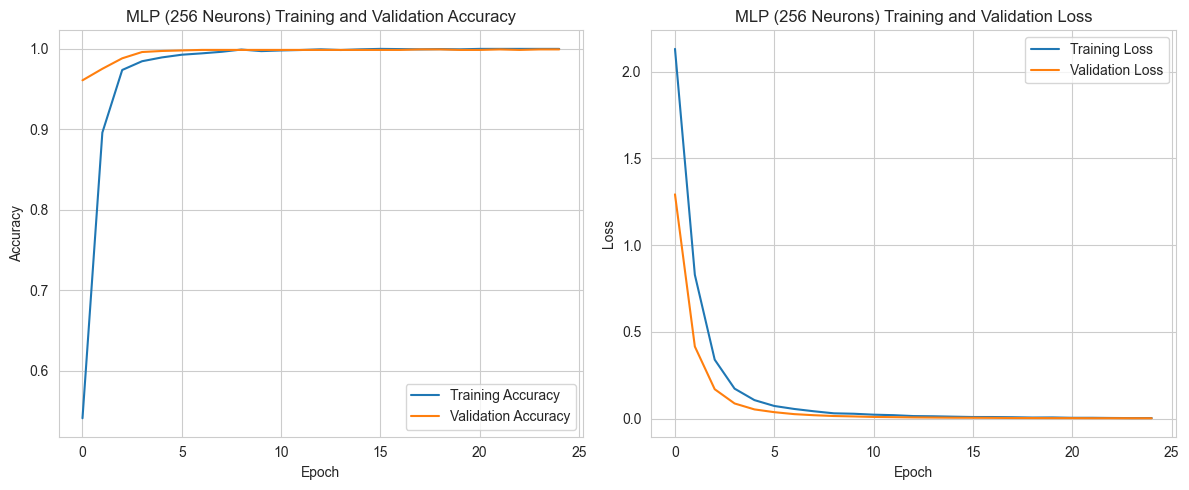

40/40 [==============================] - 0s 2ms/step


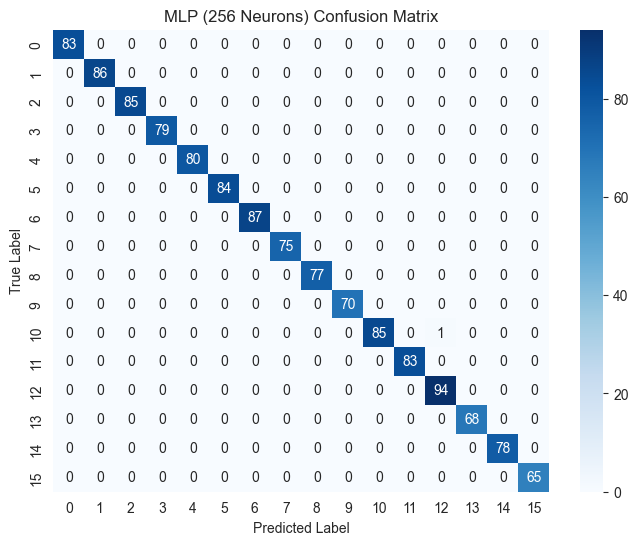

MLP (256 Neurons) Number of correct predictions: 1279
MLP (256 Neurons) Number of incorrect predictions: 1

****************************************
Testing with 512 neurons
****************************************
MLP (512 Neurons) Training Accuracy: 1.0000
MLP (512 Neurons) Validation Accuracy: 0.9993
MLP (512 Neurons) Training Loss: 0.0015
MLP (512 Neurons) Validation Loss: 0.0022


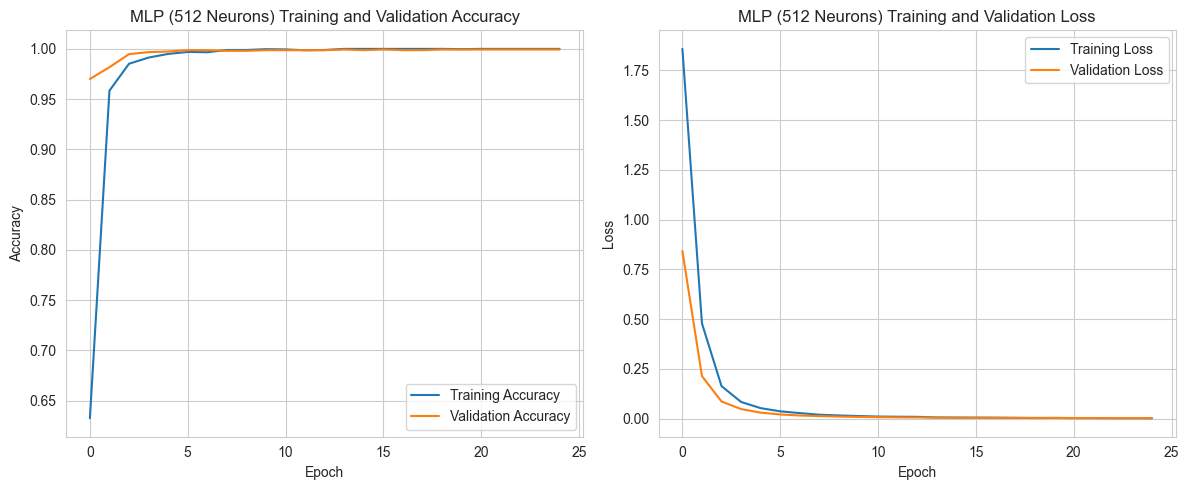

40/40 [==============================] - 0s 2ms/step


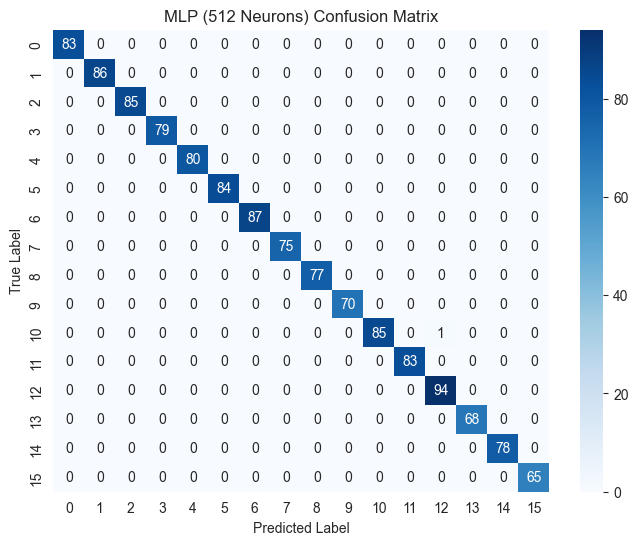

MLP (512 Neurons) Number of correct predictions: 1279
MLP (512 Neurons) Number of incorrect predictions: 1


In [214]:
# Different number of neurons to test
num_neurons_list = [2, 4, 16, 32, 64, 128, 256, 512]

for num_neurons in num_neurons_list:
    print("\n" + "*" * 40)
    print(f"Testing with {num_neurons} neurons")
    print("*" * 40)
    mlp_model_neurons = build_mlp_with_neurons(train_data_mlp.shape[1], len(np.unique(train_targets)), num_neurons)
    mlp_history_neurons = mlp_model_neurons.fit(train_data_mlp, train_targets, epochs=25, validation_split=0.3,
                                                verbose=0)

    # Report the training and validation accuracy and loss
    mlp_training_accuracy_neurons = mlp_history_neurons.history['accuracy'][-1]
    mlp_validation_accuracy_neurons = mlp_history_neurons.history['val_accuracy'][-1]
    mlp_training_loss_neurons = mlp_history_neurons.history['loss'][-1]
    mlp_validation_loss_neurons = mlp_history_neurons.history['val_loss'][-1]

    print(f"MLP ({num_neurons} Neurons) Training Accuracy: {mlp_training_accuracy_neurons:.4f}")
    print(f"MLP ({num_neurons} Neurons) Validation Accuracy: {mlp_validation_accuracy_neurons:.4f}")
    print(f"MLP ({num_neurons} Neurons) Training Loss: {mlp_training_loss_neurons:.4f}")
    print(f"MLP ({num_neurons} Neurons) Validation Loss: {mlp_validation_loss_neurons:.4f}")

    # Plot the training and validation accuracy and loss
    plt.figure(figsize=(12, 5))

    # Plot the training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(mlp_history_neurons.history['accuracy'], label='Training Accuracy')
    plt.plot(mlp_history_neurons.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'MLP ({num_neurons} Neurons) Training and Validation Accuracy')
    plt.legend()

    # Plot the training loss
    plt.subplot(1, 2, 2)
    plt.plot(mlp_history_neurons.history['loss'], label='Training Loss')
    plt.plot(mlp_history_neurons.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'MLP ({num_neurons} Neurons) Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Predict the probabilities for the attack set using the MLP model
    mlp_predicted_probabilities_neurons = mlp_model_neurons.predict(test_data_mlp)

    # Convert the predicted probabilities to class labels
    mlp_predicted_labels_neurons = np.argmax(mlp_predicted_probabilities_neurons, axis=1)

    # Generate the confusion matrix for the MLP model
    mlp_conf_matrix_neurons = confusion_matrix(test_targets, mlp_predicted_labels_neurons)

    # Plot the confusion matrix for the MLP model
    plt.figure(figsize=(8, 6))
    sns.heatmap(mlp_conf_matrix_neurons, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_targets),
                yticklabels=np.unique(test_targets))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'MLP ({num_neurons} Neurons) Confusion Matrix')
    plt.show()

    # Print the number of correct and incorrect predictions for the MLP model
    mlp_num_correct_neurons = np.sum(test_targets == mlp_predicted_labels_neurons)
    mlp_num_incorrect_neurons = len(test_targets) - mlp_num_correct_neurons
    print(f'MLP ({num_neurons} Neurons) Number of correct predictions: {mlp_num_correct_neurons}')
    print(f'MLP ({num_neurons} Neurons) Number of incorrect predictions: {mlp_num_incorrect_neurons}')